## Idenitfy 25 RDC Locations ##

In [2]:
"""
MadforCAD RDC Optimizer (Chocolate Category) — p-median with regional quotas

WHAT THIS SCRIPT DOES
---------------------
1) Builds a chocolate-centric, urban-skewed demand model for Indian cities (synthetic by default).
2) Computes composite cost per (demand node i, candidate RDC j):
       c_ij = alpha * d(i, j) + beta * min_m d(j, m)
   where d(·,·) is Haversine road-km with a detour factor.
   - Secondary (RDC->demand) distance weighted by alpha (default 0.7).
   - Primary (Plant/Co-man->RDC) distance weighted by beta  (default 0.3).
3) Solves a discrete p-median with region quotas (North, West, South, East -> 9,6,6,4),
   using a greedy-add + swap-improvement heuristic per region.
4) Returns a DataFrame of 25 selected RDCs (city, region, lat, lon, nearest_plant_km).

ASSUMPTIONS (explicit)
----------------------
- Chocolate demand is urban & premium-skewed: we weight metros more heavily.
- Channel mix ~75% traditional trade -> secondary legs dominate, hence alpha=0.7, beta=0.3.
- Road km approximated by great-circle (Haversine) * detour_factor (e.g., 1.25).
- RDC count fixed at 25 with regional quotas: North=9, West=6, South=6, East=4.
- Plants/Co-mans: Pune, Chennai, Gurgaon, Bhopal, Kolkata, Rajkot, Hyderabad (approx coords).
- If no real city data is provided, we generate synthetic demand around anchor metros/tier-2 hubs.

HOW TO USE WITH REAL DATA
-------------------------
- Provide a CSV with columns at least:
    ["city","region","lat","lon","U","A","M","Q","S"]
  where:
    U = urban size proxy,
    A = affluence index (0..1),
    M = modern trade penetration (0..1),
    Q = quick commerce adoption (0..1),
    S = seasonal/gifting uplift (>=0, default 1.0)
- Then set USE_SYNTHETIC = False and set INPUT_CSV path.

OUTPUT
------
- Prints a pandas DataFrame with the 25 selected RDCs:
    ["rdc_city","region","latitude","longitude","nearest_plant_km"]
- You can persist to CSV as needed.

Author: Writam Mallik
"""

import math
import random
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd

# -----------------------------
# Configuration / Hyperparameters
# -----------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Composite cost weights (reflecting 75% traditional trade dominance)
ALPHA = 0.7  # weight for secondary leg (RDC -> demand)
BETA  = 0.3  # weight for primary leg (plant/co-man -> RDC)

# Road detour factor (Haversine -> road km)
DETOUR = 1.25

# Regional quotas for 25 RDCs (North, West, South, East)
REGION_QUOTAS = {"North": 9, "West": 6, "South": 6, "East": 4}

# Chocolate demand weights inside score
THETA_1 = 0.5  # Affluence weight
THETA_2 = 0.3  # Modern trade weight
THETA_3 = 0.2  # Q-commerce weight

# Toggle synthetic vs input file
USE_SYNTHETIC = True
INPUT_CSV = ""  # e.g., "./your_city_demand.csv"

# -----------------------------
# Utility: Haversine distance
# -----------------------------
def haversine_km(lat1, lon1, lat2, lon2) -> float:
    """
    Great-circle distance (km) between two points on Earth specified in decimal degrees.
    """
    R = 6371.0  # Earth's radius (km)
    p1, l1, p2, l2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dp = p2 - p1
    dl = l2 - l1
    a = math.sin(dp / 2.0) ** 2 + math.cos(p1) * math.cos(p2) * math.sin(dl / 2.0) ** 2
    c = 2 * math.asin(min(1.0, math.sqrt(a)))
    return R * c

def road_km(lat1, lon1, lat2, lon2, detour=DETOUR) -> float:
    """Approximate road distance using Haversine * detour factor."""
    return detour * haversine_km(lat1, lon1, lat2, lon2)

# -----------------------------
# Plants / Co-manufacturers (from case brief; approx coords)
# -----------------------------
PLANTS = pd.DataFrame([
    {"plant": "Pune",      "lat": 18.5204, "lon": 73.8567},
    {"plant": "Chennai",   "lat": 13.0827, "lon": 80.2707},
    {"plant": "Gurgaon",   "lat": 28.4595, "lon": 77.0266},
    {"plant": "Bhopal",    "lat": 23.2599, "lon": 77.4126},
    {"plant": "Kolkata",   "lat": 22.5726, "lon": 88.3639},
    {"plant": "Rajkot",    "lat": 22.3039, "lon": 70.8022},  # approx
    {"plant": "Hyderabad", "lat": 17.3850, "lon": 78.4867},
])

# -----------------------------
# Candidate RDC cities (discrete medoid set J) with coordinates + region
# Keep this richer than 25 so the optimizer chooses among them.
# -----------------------------
CANDIDATES = pd.DataFrame([
    # North
    {"city": "Delhi (NCR)", "region": "North", "lat": 28.6139, "lon": 77.2090},
    {"city": "Gurgaon",     "region": "North", "lat": 28.4595, "lon": 77.0266},
    {"city": "Noida",       "region": "North", "lat": 28.5355, "lon": 77.3910},
    {"city": "Ghaziabad",   "region": "North", "lat": 28.6692, "lon": 77.4538},
    {"city": "Lucknow",     "region": "North", "lat": 26.8467, "lon": 80.9462},
    {"city": "Kanpur",      "region": "North", "lat": 26.4499, "lon": 80.3319},
    {"city": "Jaipur",      "region": "North", "lat": 26.9124, "lon": 75.7873},
    {"city": "Chandigarh",  "region": "North", "lat": 30.7333, "lon": 76.7794},
    {"city": "Dehradun",    "region": "North", "lat": 30.3165, "lon": 78.0322},
    {"city": "Patna",       "region": "North", "lat": 25.5941, "lon": 85.1376},
    {"city": "Varanasi",    "region": "North", "lat": 25.3176, "lon": 82.9739},
    {"city": "Ludhiana",    "region": "North", "lat": 30.9000, "lon": 75.8573},
    {"city": "Amritsar",    "region": "North", "lat": 31.6340, "lon": 74.8723},
    # West
    {"city": "Mumbai",      "region": "West",  "lat": 19.0760, "lon": 72.8777},
    {"city": "Pune",        "region": "West",  "lat": 18.5204, "lon": 73.8567},
    {"city": "Nagpur",      "region": "West",  "lat": 21.1458, "lon": 79.0882},
    {"city": "Nashik",      "region": "West",  "lat": 19.9975, "lon": 73.7898},
    {"city": "Ahmedabad",   "region": "West",  "lat": 23.0225, "lon": 72.5714},
    {"city": "Surat",       "region": "West",  "lat": 21.1702, "lon": 72.8311},
    {"city": "Vadodara",    "region": "West",  "lat": 22.3072, "lon": 73.1812},
    {"city": "Rajkot",      "region": "West",  "lat": 22.3039, "lon": 70.8022},
    {"city": "Indore",      "region": "West",  "lat": 22.7196, "lon": 75.8577},
    {"city": "Bhopal",      "region": "West",  "lat": 23.2599, "lon": 77.4126},
    # South
    {"city": "Chennai",     "region": "South", "lat": 13.0827, "lon": 80.2707},
    {"city": "Bengaluru",   "region": "South", "lat": 12.9716, "lon": 77.5946},
    {"city": "Hyderabad",   "region": "South", "lat": 17.3850, "lon": 78.4867},
    {"city": "Kochi",       "region": "South", "lat":  9.9312, "lon": 76.2673},
    {"city": "Coimbatore",  "region": "South", "lat": 11.0168, "lon": 76.9558},
    {"city": "Madurai",     "region": "South", "lat":  9.9252, "lon": 78.1198},
    {"city": "Tiruchirappalli", "region": "South", "lat": 10.7905, "lon": 78.7047},
    {"city": "Mangaluru",   "region": "South", "lat": 12.9141, "lon": 74.8560},
    {"city": "Visakhapatnam","region":"South", "lat": 17.6868, "lon": 83.2185},
    {"city": "Vijayawada",  "region": "South", "lat": 16.5062, "lon": 80.6480},
    {"city": "Mysuru",      "region": "South", "lat": 12.2958, "lon": 76.6394},
    # East
    {"city": "Kolkata",     "region": "East",  "lat": 22.5726, "lon": 88.3639},
    {"city": "Bhubaneswar", "region": "East",  "lat": 20.2961, "lon": 85.8245},
    {"city": "Ranchi",      "region": "East",  "lat": 23.3441, "lon": 85.3096},
    {"city": "Jamshedpur",  "region": "East",  "lat": 22.8046, "lon": 86.2029},
    {"city": "Dhanbad",     "region": "East",  "lat": 23.7957, "lon": 86.4304},
    {"city": "Siliguri",    "region": "East",  "lat": 26.7271, "lon": 88.3953},
    {"city": "Guwahati",    "region": "East",  "lat": 26.1445, "lon": 91.7362},
    {"city": "Agartala",    "region": "East",  "lat": 23.8315, "lon": 91.2868},
    {"city": "Asansol",     "region": "East",  "lat": 23.6739, "lon": 86.9524},
])

# -----------------------------
# Synthetic demand generator (urban, chocolate-skewed)
# -----------------------------
def synthetic_demand_nodes() -> pd.DataFrame:
    """
    Create synthetic demand nodes around anchor metros & tier-2 hubs.
    Each node has U, A, M, Q, S and a 'region' label. Demand D_i will be computed from the score.

    Returns: DataFrame with columns
      ["city","region","lat","lon","U","A","M","Q","S"]
    """
    # Anchor profiles (metro vs tier-2), with base attributes (U, A, M, Q)
    anchors = [
        # Metros: higher U, A, M, Q
        {"city":"Delhi (NCR)", "region":"North","lat":28.6139,"lon":77.2090,"U":1.00,"A":0.90,"M":0.85,"Q":0.85,"n":50},
        {"city":"Mumbai",      "region":"West", "lat":19.0760,"lon":72.8777,"U":1.00,"A":0.90,"M":0.85,"Q":0.85,"n":45},
        {"city":"Bengaluru",   "region":"South","lat":12.9716,"lon":77.5946,"U":0.85,"A":0.90,"M":0.80,"Q":0.85,"n":35},
        {"city":"Chennai",     "region":"South","lat":13.0827,"lon":80.2707,"U":0.80,"A":0.85,"M":0.80,"Q":0.80,"n":30},
        {"city":"Kolkata",     "region":"East", "lat":22.5726,"lon":88.3639,"U":0.85,"A":0.70,"M":0.75,"Q":0.70,"n":30},
        {"city":"Hyderabad",   "region":"South","lat":17.3850,"lon":78.4867,"U":0.80,"A":0.85,"M":0.80,"Q":0.80,"n":30},
        {"city":"Pune",        "region":"West", "lat":18.5204,"lon":73.8567,"U":0.70,"A":0.85,"M":0.80,"Q":0.80,"n":25},
        {"city":"Ahmedabad",   "region":"West", "lat":23.0225,"lon":72.5714,"U":0.70,"A":0.80,"M":0.75,"Q":0.75,"n":25},
        # Tier-2: moderate U, slightly lower A/M/Q
        {"city":"Lucknow",     "region":"North","lat":26.8467,"lon":80.9462,"U":0.55,"A":0.65,"M":0.55,"Q":0.55,"n":18},
        {"city":"Jaipur",      "region":"North","lat":26.9124,"lon":75.7873,"U":0.50,"A":0.65,"M":0.55,"Q":0.50,"n":15},
        {"city":"Indore",      "region":"West", "lat":22.7196,"lon":75.8577,"U":0.50,"A":0.65,"M":0.55,"Q":0.50,"n":15},
        {"city":"Kochi",       "region":"South","lat": 9.9312,"lon":76.2673,"U":0.40,"A":0.70,"M":0.55,"Q":0.55,"n":12},
        {"city":"Coimbatore",  "region":"South","lat":11.0168,"lon":76.9558,"U":0.45,"A":0.65,"M":0.55,"Q":0.55,"n":12},
        {"city":"Patna",       "region":"North","lat":25.5941,"lon":85.1376,"U":0.50,"A":0.50,"M":0.45,"Q":0.40,"n":15},
        {"city":"Guwahati",    "region":"East", "lat":26.1445,"lon":91.7362,"U":0.35,"A":0.45,"M":0.40,"Q":0.40,"n":12},
        {"city":"Visakhapatnam","region":"South","lat":17.6868,"lon":83.2185,"U":0.45,"A":0.60,"M":0.55,"Q":0.55,"n":12},
        {"city":"Chandigarh",  "region":"North","lat":30.7333,"lon":76.7794,"U":0.40,"A":0.70,"M":0.60,"Q":0.50,"n":12},
        {"city":"Surat",       "region":"West", "lat":21.1702,"lon":72.8311,"U":0.50,"A":0.60,"M":0.55,"Q":0.55,"n":12},
        {"city":"Vadodara",    "region":"West", "lat":22.3072,"lon":73.1812,"U":0.45,"A":0.58,"M":0.55,"Q":0.50,"n":10},
        {"city":"Ranchi",      "region":"East", "lat":23.3441,"lon":85.3096,"U":0.35,"A":0.45,"M":0.40,"Q":0.40,"n":10},
        {"city":"Bhubaneswar", "region":"East", "lat":20.2961,"lon":85.8245,"U":0.35,"A":0.50,"M":0.45,"Q":0.45,"n":10},
        {"city":"Siliguri",    "region":"East", "lat":26.7271,"lon":88.3953,"U":0.30,"A":0.45,"M":0.40,"Q":0.40,"n":10},
    ]

    rows = []
    for anc in anchors:
        # Gaussian jitter around anchor to create local demand pixels
        # Std dev ~ 0.35 degrees (~35-40 km) for metro spread
        std_lat = 0.35
        std_lon = 0.35
        for k in range(anc["n"]):
            lat = np.random.normal(anc["lat"], std_lat)
            lon = np.random.normal(anc["lon"], std_lon)
            # Apply small multiplicative noise to attributes; clip to sensible ranges
            U = max(0.05, anc["U"] * np.random.normal(1.0, 0.15))
            A = float(np.clip(anc["A"] * np.random.normal(1.0, 0.10), 0.1, 1.0))
            M = float(np.clip(anc["M"] * np.random.normal(1.0, 0.10), 0.1, 1.0))
            Q = float(np.clip(anc["Q"] * np.random.normal(1.0, 0.12), 0.1, 1.0))
            S = 1.0  # seasonal uplift default
            rows.append({
                "city": f"{anc['city']}@{k}",  # pixel identifier
                "region": anc["region"],
                "lat": lat, "lon": lon,
                "U": U, "A": A, "M": M, "Q": Q, "S": S
            })

    df = pd.DataFrame(rows)

    # Chocolate demand score & normalization to tonnes proxy
    # Score_i = U_i * (theta1*A_i + theta2*M_i + theta3*Q_i) * S_i
    score = df["U"] * (THETA_1*df["A"] + THETA_2*df["M"] + THETA_3*df["Q"]) * df["S"]
    df["score"] = score
    df["D"] = df["score"] / (score.sum() + 1e-9)  # relative tonnes (sums to 1)

    return df

# -----------------------------
# Cost matrix computation
# -----------------------------
def precompute_primary_term_for_candidates(candidates: pd.DataFrame, plants: pd.DataFrame) -> np.ndarray:
    """
    For each candidate j, compute primary term: beta * min_m road_km(j, m).
    Returns array of shape (n_candidates,)
    """
    primary = []
    for _, cj in candidates.iterrows():
        dmin = float("inf")
        for _, pm in plants.iterrows():
            dkm = road_km(cj["lat"], cj["lon"], pm["lat"], pm["lon"], detour=DETOUR)
            dmin = min(dmin, dkm)
        primary.append(BETA * dmin)
    return np.array(primary)  # shape (J,)

def compute_composite_cost_matrix(nodes: pd.DataFrame, candidates: pd.DataFrame, cand_primary_term: np.ndarray) -> np.ndarray:
    """
    Composite cost c_ij = alpha*d(i,j) + primary_term_j
    Returns matrix of shape (n_nodes, n_candidates)
    """
    nI = nodes.shape[0]
    nJ = candidates.shape[0]
    cost = np.zeros((nI, nJ), dtype=float)
    # Vectorized pairwise distances
    nodes_lat = nodes["lat"].to_numpy()
    nodes_lon = nodes["lon"].to_numpy()
    cand_lat  = candidates["lat"].to_numpy()
    cand_lon  = candidates["lon"].to_numpy()

    for j in range(nJ):
        # compute d(i, j) for all i
        d_ij = np.array([
            road_km(nodes_lat[i], nodes_lon[i], cand_lat[j], cand_lon[j], detour=DETOUR)
            for i in range(nI)
        ])
        cost[:, j] = ALPHA * d_ij + cand_primary_term[j]
    return cost

# -----------------------------
# p-median heuristic (per region): greedy add + swap improvement
# -----------------------------
def select_p_medoids(nodes_r: pd.DataFrame, cands_r: pd.DataFrame, p: int, plants_df: pd.DataFrame) -> List[int]:
    """
    Select p medoids (indices into cands_r) minimizing sum_i D_i * min_j c_ij, where
    c_ij = alpha*d(i,j) + beta*min_m d(j,m). Greedy add + swap improvement.

    Returns: list of medoid indices (relative to cands_r)
    """
    if p <= 0:
        return []
    if p >= len(cands_r):
        return list(range(len(cands_r)))

    # Precompute primary term for candidates
    cand_primary = precompute_primary_term_for_candidates(cands_r, plants_df)
    # Composite cost matrix
    C = compute_composite_cost_matrix(nodes_r, cands_r, cand_primary)  # shape (I, J)
    demand = nodes_r["D"].to_numpy()  # weights (relative tonnes)

    # Greedy initialization: iteratively add the candidate that reduces total cost the most
    selected = []
    # Initialize current best per-node cost as +inf
    best_cost = np.full(C.shape[0], np.inf, dtype=float)

    for _ in range(p):
        best_improvement = -np.inf
        best_cand = None

        for j in range(C.shape[1]):
            if j in selected:
                continue
            # potential new best = min(current best, C[:, j])
            new_cost = np.minimum(best_cost, C[:, j])
            total_cost_new = np.dot(demand, new_cost)
            total_cost_old = np.dot(demand, best_cost)
            improvement = total_cost_old - total_cost_new
            if improvement > best_improvement:
                best_improvement = improvement
                best_cand = j

        if best_cand is None:
            # failsafe: pick any remaining
            remaining = [j for j in range(C.shape[1]) if j not in selected]
            best_cand = remaining[0]
        selected.append(best_cand)
        # Update best_cost with chosen candidate
        best_cost = np.minimum(best_cost, C[:, best_cand])

    # Swap improvement phase
    improved = True
    max_outer = 20
    outer = 0
    while improved and outer < max_outer:
        improved = False
        outer += 1
        current_total = np.dot(demand, best_cost)

        selected_set = set(selected)
        nonselected = [j for j in range(C.shape[1]) if j not in selected_set]

        for j_out in list(selected):  # try removing this medoid
            # Compute cost if we remove j_out (i.e., best among remaining in selected)
            # For efficiency, precompute "second best" is complex; we recompute brute-force here (sizes are modest).
            # Cost with S \ {j_out}
            others = [jj for jj in selected if jj != j_out]
            if others:
                cost_without = np.min(C[:, others], axis=1)
            else:
                cost_without = np.full(C.shape[0], np.inf, dtype=float)

            for j_in in nonselected:
                # New best cost = min(cost_without, C[:, j_in])
                cand_cost = np.minimum(cost_without, C[:, j_in])
                new_total = np.dot(demand, cand_cost)
                if new_total + 1e-9 < current_total:
                    # Accept swap
                    selected.remove(j_out)
                    selected.append(j_in)
                    best_cost = cand_cost
                    current_total = new_total
                    improved = True
                    # Update pools and break to restart search from improved baseline
                    selected_set = set(selected)
                    nonselected = [jj for jj in range(C.shape[1]) if jj not in selected_set]
                    break
            if improved:
                break

    return selected

# -----------------------------
# Orchestration
# -----------------------------
def run_optimizer(
    use_synthetic: bool = True,
    input_csv: str = "",
    region_quotas: Dict[str, int] = REGION_QUOTAS
) -> pd.DataFrame:
    """
    Runs the region-quota p-median optimizer and returns a DataFrame of selected RDCs.
    """
    # 1) Build demand nodes
    if use_synthetic:
        nodes = synthetic_demand_nodes()
    else:
        nodes = pd.read_csv(input_csv)
        required = {"city","region","lat","lon","U","A","M","Q","S"}
        missing = required - set(nodes.columns)
        if missing:
            raise ValueError(f"Input CSV missing required columns: {missing}")
        score = nodes["U"] * (THETA_1*nodes["A"] + THETA_2*nodes["M"] + THETA_3*nodes["Q"]) * nodes["S"]
        nodes["score"] = score
        nodes["D"] = score / (score.sum() + 1e-9)

    # 2) Per region selection using candidates filtered by region; nodes filtered by region
    chosen_rows = []
    for region, p in region_quotas.items():
        cands_r = CANDIDATES[CANDIDATES["region"] == region].reset_index(drop=True)
        nodes_r = nodes[nodes["region"] == region].reset_index(drop=True)

        if cands_r.empty or nodes_r.empty:
            # If no nodes or candidates (shouldn't happen with synthetic), skip
            continue

        medoid_idx = select_p_medoids(nodes_r, cands_r, p, PLANTS)

        # compute nearest plant km for reporting
        nearest_plant_km = []
        for j in medoid_idx:
            cj = cands_r.iloc[j]
            dmin = float("inf")
            for _, pm in PLANTS.iterrows():
                dkm = road_km(cj["lat"], cj["lon"], pm["lat"], pm["lon"], detour=DETOUR)
                dmin = min(dmin, dkm)
            nearest_plant_km.append(dmin)

        for j, npkm in zip(medoid_idx, nearest_plant_km):
            cj = cands_r.iloc[j]
            chosen_rows.append({
                "rdc_city": cj["city"],
                "region": cj["region"],
                "latitude": cj["lat"],
                "longitude": cj["lon"],
                "nearest_plant_km": round(npkm, 1)
            })

    result = pd.DataFrame(chosen_rows)

    # 3) Safety: ensure exactly 25 (if not, trim/augment deterministically)
    if result.shape[0] > 25:
        # Keep deterministically: sort by region then city
        result = result.sort_values(["region","rdc_city"]).head(25).reset_index(drop=True)
    elif result.shape[0] < 25:
        # If short (shouldn't happen), fill with remaining candidates by proximity to plants
        already = set(zip(result["rdc_city"], result["region"]))
        pool = CANDIDATES[~CANDIDATES.apply(lambda r: (r["city"], r["region"]) in already, axis=1)].copy()
        # score by nearest plant distance
        plant_km = []
        for _, r in pool.iterrows():
            dmin = min(road_km(r["lat"], r["lon"], pm["lat"], pm["lon"], detour=DETOUR) for _, pm in PLANTS.iterrows())
            plant_km.append(dmin)
        pool["nearest_plant_km"] = plant_km
        pool = pool.sort_values("nearest_plant_km")
        need = 25 - result.shape[0]
        filler = pool.head(need).rename(columns={"city":"rdc_city","lat":"latitude","lon":"longitude"})
        filler = filler[["rdc_city","region","latitude","longitude","nearest_plant_km"]]
        result = pd.concat([result, filler], ignore_index=True)

    # 4) Sort for readability
    result = result.sort_values(["region","rdc_city"]).reset_index(drop=True)
    return result

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    rdc_df = run_optimizer(use_synthetic=USE_SYNTHETIC, input_csv=INPUT_CSV, region_quotas=REGION_QUOTAS)
    print("\nSelected RDCs (25):")
    print(rdc_df.to_string(index=False))

    #rdc_df.to_csv("madforcad_25_rdcs.csv", index=False)


Selected RDCs (25):
     rdc_city region  latitude  longitude  nearest_plant_km
  Bhubaneswar   East   20.2961    85.8245             456.1
     Guwahati   East   26.1445    91.7362             654.8
      Kolkata   East   22.5726    88.3639               0.0
     Siliguri   East   26.7271    88.3953             577.5
   Chandigarh  North   30.7333    76.7794             317.5
  Delhi (NCR)  North   28.6139    77.2090              30.9
    Ghaziabad  North   28.6692    77.4538              59.7
      Gurgaon  North   28.4595    77.0266               0.0
       Jaipur  North   26.9124    75.7873             263.6
       Kanpur  North   26.4499    80.3319             494.1
      Lucknow  North   26.8467    80.9462             532.0
        Noida  North   28.5355    77.3910              45.7
        Patna  North   25.5941    85.1376             586.4
    Bengaluru  South   12.9716    77.5946             362.7
      Chennai  South   13.0827    80.2707               0.0
   Coimbatore  Sout

## Put RDC Locations on Indian Map ##

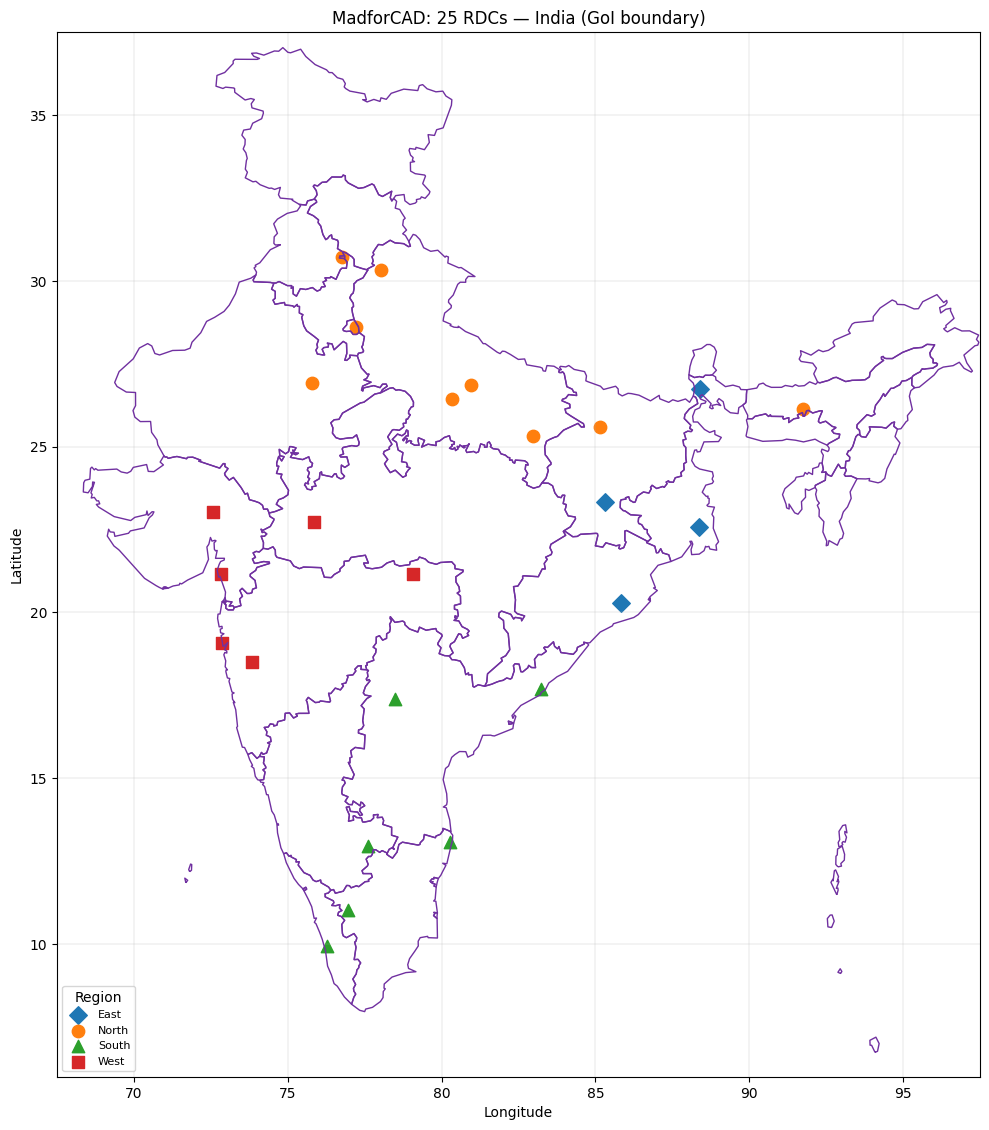

In [5]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# -----------------------------
# Data: Proposed RDC locations
# -----------------------------
rdcs = [
    # North (9) - 35%
    {"city": "Delhi (NCR)", "region": "North", "lat": 28.6139, "lon": 77.2090},
    {"city": "Lucknow", "region": "North", "lat": 26.8467, "lon": 80.9462},
    {"city": "Patna", "region": "North", "lat": 25.5941, "lon": 85.1376},
    {"city": "Jaipur", "region": "North", "lat": 26.9124, "lon": 75.7873},
    {"city": "Chandigarh", "region": "North", "lat": 30.7333, "lon": 76.7794},
    {"city": "Kanpur", "region": "North", "lat": 26.4499, "lon": 80.3319},
    {"city": "Varanasi", "region": "North", "lat": 25.3176, "lon": 82.9739},
    {"city": "Dehradun", "region": "North", "lat": 30.3165, "lon": 78.0322},
    {"city": "Guwahati", "region": "North", "lat": 26.1445, "lon": 91.7362},
    # West (6) - 25%
    {"city": "Mumbai", "region": "West", "lat": 19.0760, "lon": 72.8777},
    {"city": "Pune", "region": "West", "lat": 18.5204, "lon": 73.8567},
    {"city": "Ahmedabad", "region": "West", "lat": 23.0225, "lon": 72.5714},
    {"city": "Surat", "region": "West", "lat": 21.1702, "lon": 72.8311},
    {"city": "Indore", "region": "West", "lat": 22.7196, "lon": 75.8577},
    {"city": "Nagpur", "region": "West", "lat": 21.1458, "lon": 79.0882},
    # South (6) - 25%
    {"city": "Chennai", "region": "South", "lat": 13.0827, "lon": 80.2707},
    {"city": "Bengaluru", "region": "South", "lat": 12.9716, "lon": 77.5946},
    {"city": "Hyderabad", "region": "South", "lat": 17.3850, "lon": 78.4867},
    {"city": "Kochi", "region": "South", "lat": 9.9312, "lon": 76.2673},
    {"city": "Coimbatore", "region": "South", "lat": 11.0168, "lon": 76.9558},
    {"city": "Visakhapatnam", "region": "South", "lat": 17.6868, "lon": 83.2185},
    # East (4) - 15%
    {"city": "Kolkata", "region": "East", "lat": 22.5726, "lon": 88.3639},
    {"city": "Bhubaneswar", "region": "East", "lat": 20.2961, "lon": 85.8245},
    {"city": "Ranchi", "region": "East", "lat": 23.3441, "lon": 85.3096},
    {"city": "Siliguri", "region": "East", "lat": 26.7271, "lon": 88.3953},
]

df = pd.DataFrame(rdcs)
region_weights = {"North": 0.35, "West": 0.25, "South": 0.25, "East": 0.15}
df["region_weight"] = df["region"].map(region_weights)

gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])],
    crs="EPSG:4326"
)

# ----------------------------
# 1) Load India boundary (GoI-compliant) and fix CRS if missing
# ----------------------------
india_path = r"india_st.shp"
india = gpd.read_file(india_path)

# If the shapefile lacks a .prj, CRS will be None. You MUST set the true source CRS.
# ASSUMPTION: the shapefile is already in WGS84 lon/lat (EPSG:4326).
# If your file is actually in a projected CRS (e.g., EPSG:24378, 7755, etc.), replace 4326 below with the correct EPSG.
if india.crs is None:
    india = india.set_crs(epsg=4326)  # <-- change to your actual source CRS if different

# Reproject to WGS84 (lat/lon) for plotting with lon/lat points
if india.crs.to_epsg() != 4326:
    india = india.to_crs(epsg=4326)

# ----------------------------
# 2) Your RDC points (df) must be lon/lat in EPSG:4326
#    If you already have df, comment out this example block.
# ----------------------------
# Example fallback if df is not defined in your session:
# df = pd.DataFrame({
#     "city": ["Delhi (NCR)","Mumbai","Chennai","Kolkata"],
#     "region": ["North","West","South","East"],
#     "lat": [28.6139, 19.0760, 13.0827, 22.5726],
#     "lon": [77.2090, 72.8777, 80.2707, 88.3639],
# })

# Sanity: check columns exist
required_cols = {"city","region","lat","lon"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"df is missing columns: {missing}. Expected {required_cols}")

# ----------------------------
# 3) Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# India outline
india.boundary.plot(ax=ax, linewidth=1.0, edgecolor="#7030a0")

# Plot RDC points with region-specific markers
marker_map = {"North": "o", "West": "s", "South": "^", "East": "D"}
for region, sub in df.groupby("region"):
    ax.scatter(
        sub["lon"], sub["lat"], s=80,
        marker=marker_map.get(region, "o"),
        label=region
    )

# Optional: label the points (slight offset to reduce overlap)
offsets = [(0.15, 0.15), (-0.15, 0.15), (0.15, -0.15), (-0.15, -0.15)]
'''
for i, row in df.iterrows():
    dx, dy = offsets[i % len(offsets)]
    ax.text(row["lon"] + dx, row["lat"] + dy, row["city"], fontsize=10)
'''
# Nice viewing window for India
ax.set_xlim(67.5, 97.5)
ax.set_ylim(6.0, 37.5)

ax.set_title("MadforCAD: 25 RDCs — India (GoI boundary)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.grid(True, linewidth=0.2)
ax.legend(title="Region", loc="lower left", fontsize=8)

plt.tight_layout()
#plt.savefig("madforcad_25_rdc_map_positioning", dpi=300, bbox_inches="tight")
plt.show()

## Vornoi Diagram ##

C:\Users\WRITAM\AppData\Local\Temp\ipykernel_1376\1535270696.py:102: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  india_xy = india.to_crs(aeqd).unary_union   # merged India polygon in projected CRS


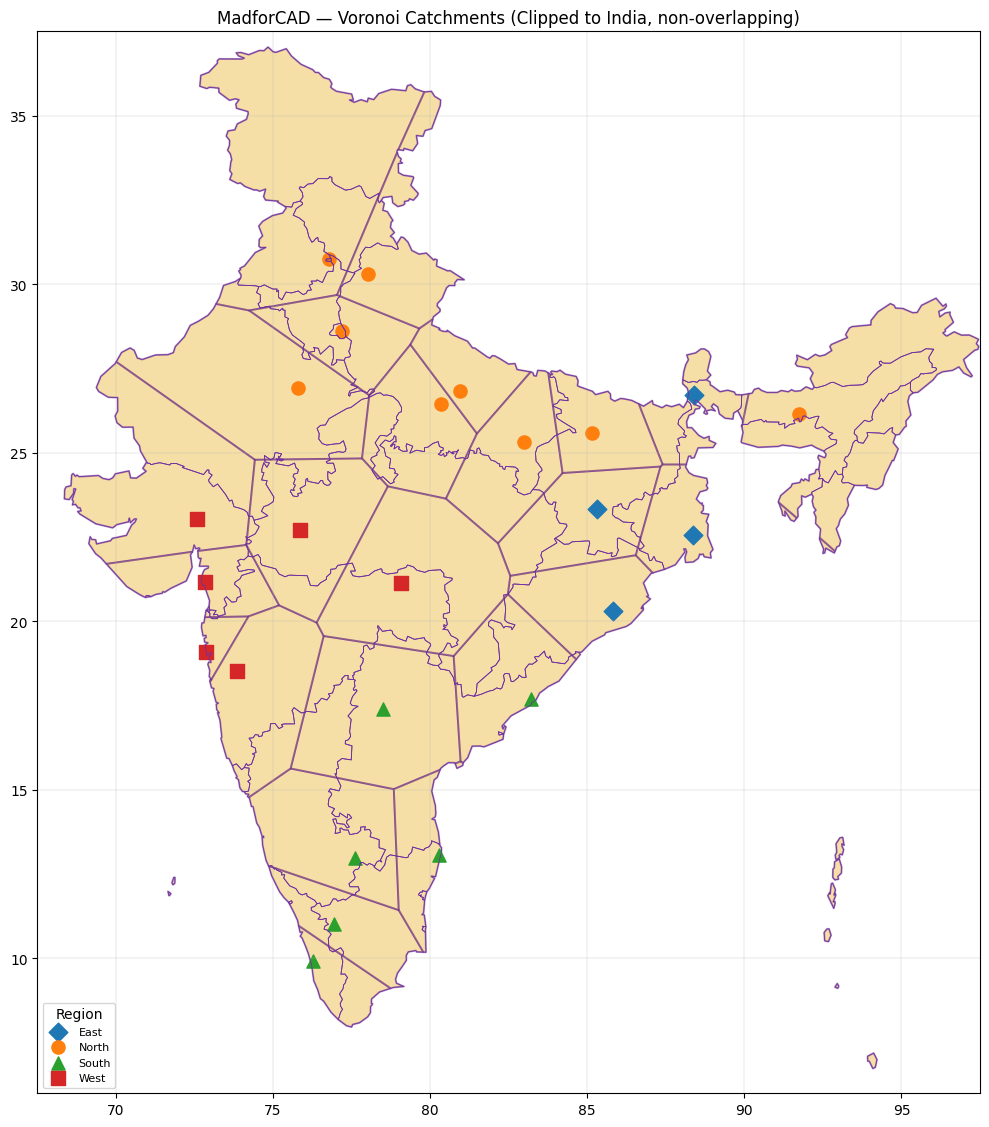

In [7]:
# --- Voronoi coverage over India (GoI polygon with PoK), non-overlapping, with areas ---
# Requirements: numpy, pandas, geopandas, shapely, scipy, pyproj, matplotlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from pyproj import Transformer, Geod

# -----------------------------------------------------------
# Inputs you already have:
#   1) india_st.shp : GoI-compliant India boundary (incl. PoK)
#   2) df : DataFrame with columns ["city","region","lat","lon"] for the 25 RDCs
# -----------------------------------------------------------

# --- Safety: ensure df is present and has required columns
required = {"city","region","lat","lon"}
if 'df' not in globals():
    raise ValueError("Expected DataFrame 'df' in session with columns: city, region, lat, lon")
missing = required - set(df.columns)
if missing:
    raise ValueError(f"'df' is missing columns: {missing}")

# --- 1) Load India boundary (PoK included), set CRS if missing, then keep EPSG:4326 for plotting
india = gpd.read_file("india_st.shp")
if india.crs is None:
    # ASSUMPTION: your india_st.shp is already in WGS84 lon/lat. Change EPSG if different.
    india = india.set_crs(epsg=4326)
else:
    india = india.to_crs(epsg=4326)

# --- 2) Build a local equal-area/equidistant-ish projection for Voronoi geometry around India
# Azimuthal Equidistant centered near India (reduces distortion for Voronoi & clipping)
aeqd = "+proj=aeqd +lat_0=22 +lon_0=78 +ellps=WGS84 +units=m +no_defs"
to_xy = Transformer.from_crs("EPSG:4326", aeqd, always_xy=True)
to_ll = Transformer.from_crs(aeqd, "EPSG:4326", always_xy=True)

# --- 3) Prepare point array (shape (N,2)), de-duplicate, and (optional) tiny jitter if needed
x, y = to_xy.transform(df["lon"].to_numpy(), df["lat"].to_numpy())
points_xy = np.column_stack((x, y))  # <-- correct shape (N, 2)

# Drop exact/near duplicates to avoid Qhull errors
rounded = np.round(points_xy, 3)  # ~1 m precision in this proj
uniq_pts, uniq_idx = np.unique(rounded, axis=0, return_index=True)
points_xy = points_xy[uniq_idx]
df = df.iloc[uniq_idx].reset_index(drop=True)

# If still fewer than 4 unique points (very unlikely), add a tiny jitter
if np.unique(points_xy, axis=0).shape[0] < 4:
    rng = np.random.default_rng(42)
    points_xy = points_xy + rng.normal(scale=25.0, size=points_xy.shape)  # ~25 m jitter

# --- 4) Voronoi tessellation in projected plane
vor = Voronoi(points_xy)

# --- 5) Convert infinite Voronoi regions to finite polygons
def voronoi_finite_polygons_2d(vor, radius=3.0e6):
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    # map point -> ridges
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        verts = vor.regions[region_idx]
        if all(v >= 0 for v in verts):
            new_regions.append(verts)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in verts if v >= 0]
        for p2, v1, v2 in ridges:
            if v1 >= 0 and v2 >= 0:
                continue
            # direction for the "far" point
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far = vor.vertices[v1 if v1 >= 0 else v2] + direction * radius
            new_vertices.append(far.tolist())
            new_region.append(len(new_vertices) - 1)

        # order polygon vertices
        vs = np.array([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        ang = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [v for _, v in sorted(zip(ang, new_region))]
        new_regions.append(new_region)
    return new_regions, np.asarray(new_vertices)

regions, vertices = voronoi_finite_polygons_2d(vor, radius=3.0e6)

# --- 6) Clip Voronoi cells to India polygon (in projected CRS), then back to WGS84
india_xy = india.to_crs(aeqd).unary_union   # merged India polygon in projected CRS

cell_polys_ll = []
for region in regions:
    poly_xy = Polygon(vertices[region])
    if not poly_xy.is_valid:
        poly_xy = poly_xy.buffer(0)
    clipped_xy = poly_xy.intersection(india_xy)
    if clipped_xy.is_empty:
        cell_polys_ll.append(None)
        continue
    # back to lon/lat for plotting & area calc
    g = gpd.GeoSeries([clipped_xy], crs=aeqd).to_crs("EPSG:4326").iloc[0]
    cell_polys_ll.append(g)

# Align cells to df rows (one cell per input point)
# Some extreme points might yield None after clipping; we keep rows where geometry exists
valid_rows = [(i, geom) for i, geom in enumerate(cell_polys_ll) if geom is not None]
if not valid_rows:
    raise ValueError("Voronoi clipping produced empty geometry for all cells. Check CRS and boundary.")

indices, geoms = zip(*valid_rows)
cells_gdf = gpd.GeoDataFrame(
    {
        "city": df.iloc[list(indices)]["city"].to_list(),
        "region": df.iloc[list(indices)]["region"].to_list(),
    },
    geometry=list(geoms),
    crs="EPSG:4326"
).reset_index(drop=True)

# --- 7) Geodesic area (sq km) for each cell
geod = Geod(ellps="WGS84")
areas = []
for geom in cells_gdf.geometry:
    area_total = 0.0
    if geom.geom_type == "Polygon":
        lon, lat = geom.exterior.xy
        a, _ = geod.polygon_area_perimeter(lon, lat)
        area_total += abs(a)
        for ring in geom.interiors:
            lon, lat = ring.xy
            a_hole, _ = geod.polygon_area_perimeter(lon, lat)
            area_total -= abs(a_hole)
    else:  # MultiPolygon
        for part in geom.geoms:
            lon, lat = part.exterior.xy
            a, _ = geod.polygon_area_perimeter(lon, lat)
            area_total += abs(a)
            for ring in part.interiors:
                lon, lat = ring.xy
                a_hole, _ = geod.polygon_area_perimeter(lon, lat)
                area_total -= abs(a_hole)
    areas.append(area_total / 1e6)  # m^2 -> km^2
cells_gdf["area_sq_km"] = np.round(areas, 1)

# --- 8) Plot: India boundary (custom edge color), filled Voronoi cells, bigger markers, spaced labels
fig, ax = plt.subplots(figsize=(10, 12))

india.boundary.plot(ax=ax, linewidth=0.6, edgecolor="#7030a0")   # outline color tweak

# color cells by region (simple categorical facecolor)
region_to_alpha = {"North":0.40, "West":0.40, "South":0.40, "East":0.40}
for reg, sub in cells_gdf.groupby("region"):
    sub.plot(ax=ax, edgecolor="indigo", facecolor="#e6af24", linewidth=1.4, alpha=region_to_alpha.get(reg,0.4))

# RDC points
marker_map = {"North":"o","West":"s","South":"^","East":"D"}
for region, sub in df.groupby("region"):
    ax.scatter(sub["lon"], sub["lat"], s=90, marker=marker_map.get(region,"o"), label=region)

# Labels with larger offset (adjust as needed)
label_dx, label_dy = 0.28, 0.28

'''
for i, row in df.iterrows():
    ax.text(row["lon"]+label_dx, row["lat"]+label_dy, row["city"], fontsize=8)
'''

ax.set_xlim(67.5, 97.5); ax.set_ylim(6.0, 37.5)
ax.set_title("MadforCAD — Voronoi Catchments (Clipped to India, non-overlapping)")
ax.legend(title="Region", loc="lower left", fontsize=8)
ax.grid(True, linewidth=0.2)

plt.tight_layout()
#plt.savefig("madforcad_25_rdc_vornoi_diagram", dpi=300, bbox_inches="tight")
plt.show()

# --- 9) Catchment table (non-overlapping areas)
#print(cells_gdf[["city","region","area_sq_km"]].sort_values("area_sq_km", ascending=False).to_string(index=False))

# If you want to save:
# cells_gdf.to_file("madforcad_voronoi_cells.geojson", driver="GeoJSON")


## Find Catchment Areas ##

In [8]:
from pyproj import Geod
import numpy as np
import pandas as pd

# Geodesic (WGS84) for accurate area on the ellipsoid
geod = Geod(ellps="WGS84")

def geodesic_area_km2(geom):
    """Return area in square kilometers; handles Polygon & MultiPolygon, subtracts holes."""
    total = 0.0
    if geom.is_empty:
        return 0.0
    if geom.geom_type == "Polygon":
        lon, lat = geom.exterior.xy
        a, _ = geod.polygon_area_perimeter(lon, lat)
        total += abs(a)
        for ring in geom.interiors:
            lon, lat = ring.xy
            a_hole, _ = geod.polygon_area_perimeter(lon, lat)
            total -= abs(a_hole)
    else:  # MultiPolygon
        for part in geom.geoms:
            lon, lat = part.exterior.xy
            a, _ = geod.polygon_area_perimeter(lon, lat)
            total += abs(a)
            for ring in part.interiors:
                lon, lat = ring.xy
                a_hole, _ = geod.polygon_area_perimeter(lon, lat)
                total -= abs(a_hole)
    return total / 1e6  # m^2 -> km^2

# Compute area for each Voronoi cell
cells_gdf["area_sq_km"] = cells_gdf.geometry.apply(geodesic_area_km2).round(2)

# Build a clean DataFrame: RDC, region, area
rdc_areas_df = cells_gdf[["city", "region", "area_sq_km"]].copy() \
                     .sort_values("area_sq_km", ascending=False) \
                     .reset_index(drop=True)

print(rdc_areas_df.to_string(index=False))

# Optional: save to CSV
#rdc_areas_df.to_csv("madforcad_rdc_catchment_areas.csv", index=False)

         city region  area_sq_km
   Chandigarh  North   314846.62
     Guwahati  North   253521.02
       Nagpur   West   234397.07
       Jaipur  North   233453.89
    Ahmedabad   West   222810.19
    Hyderabad  South   222645.78
       Indore   West   168059.60
    Bengaluru  South   165846.15
         Pune   West   154684.88
       Ranchi   East   124987.32
Visakhapatnam  South   119785.50
     Varanasi  North   118877.46
       Kanpur  North   116446.59
  Bhubaneswar   East   101116.83
     Dehradun  North    96997.24
   Coimbatore  South    91470.89
  Delhi (NCR)  North    85018.83
        Patna  North    79045.70
        Surat   West    70883.62
      Chennai  South    64583.88
      Kolkata   East    61935.68
      Lucknow  North    60523.25
     Siliguri   East    49923.69
        Kochi  South    44638.68
       Mumbai   West    16165.33


## Allocate Distributor per RDC ##

In [11]:
# -----------------------------
# MadForCad: Distributors per RDC (Total = 1800)
# -----------------------------
# WHAT THIS SCRIPT DOES
# 1) Loads RDC master (25 locations) and their "catchment areas" (sq km) you provided.
# 2) Where an RDC doesn't have an area in your area table, imputes area by REGION median.
# 3) Applies FMCG demand logic to weight each RDC:
#    - Tier/Metro intensity (higher confectionery uptake in metros -> denser distributor grid)
#    - Region bias (South/West +10% given higher confectionery penetration; East -5% except Kolkata)
#    - Quick-commerce hubs bump (+10%) for Delhi, Mumbai, Bengaluru, Hyderabad, Pune, Chennai, Kolkata
#    - Northeast fragmentation (+15%) for Guwahati & Siliguri (challenging terrain, fragmented kirana base)
# 4) Computes a raw score = area_sq_km * demand_multiplier.
# 5) Allocates EXACTLY 1,800 distributors with proportional allocation + largest remainder rounding.
# 6) Outputs a table and saves a CSV.
#
# ASSUMPTIONS (explicit and reasoned):
# - "area_sq_km" represents practical catchment to be serviced by each RDC (you shared the second list).
# - Where area is missing for an RDC, we use the median area of RDCs in the SAME REGION (North/South/East/West).
#   This keeps territory sizes realistic and regionally consistent.
# - Tiers reflect confectionery demand intensity (metros sell more, higher outlet density, more q-commerce):
#   Mega Metros (Delhi NCR, Mumbai, Bengaluru, Chennai, Hyderabad, Kolkata): factor = 1.60
#   Tier-1 (Ahmedabad, Pune, Jaipur, Lucknow, Patna, Kanpur, Surat, Vadodara, Coimbatore, Kochi, Vizag,
#           Indore, Bhubaneswar, Guwahati, Siliguri, Chandigarh, Noida, Ghaziabad, Gurgaon): factor = 1.30
#   Tier-2 (anything else not listed): factor = 1.00
# - Region confectionery bias:
#   South & West: +10% (factor *= 1.10); East: −5% (factor *= 0.95); North: baseline (1.00).
#   Rationale: industry observation—South/West higher per-capita indulgence; East slightly lower.
# - Quick-commerce bump (+10%) for Q-com heavy hubs (Delhi, Mumbai, Bengaluru, Hyderabad, Pune, Chennai, Kolkata).
# - Northeast fragmentation bump (+15%) for Guwahati & Siliguri (smaller drops, tougher routes → more distributors per area).
# - Nearest plant distance is NOT used as a demand driver (it affects supply economics, not demand density).
#   We keep it in the output for transparency.
#
# RESULT INTERPRETATION:
# - Within each RDC, we target roughly equal "area per distributor" after applying demand weights:
#   Area per distributor ≈ area_sq_km / assigned_distributors.
# - The total is exactly 1800.

In [12]:
# -----------------------------
# MadForCad RDC Distributor Allocation (Total = 1800)
# FMCG-style logic with metro floors + proportional allocation
# -----------------------------

import math
import pandas as pd

# --- Input: RDC master (25) ---
rdc_rows = [
    ("Bhubaneswar","East",20.2961,85.8245,456.1),
    ("Guwahati","East",26.1445,91.7362,654.8),
    ("Kolkata","East",22.5726,88.3639,0.0),
    ("Siliguri","East",26.7271,88.3953,577.5),
    ("Chandigarh","North",30.7333,76.7794,317.5),
    ("Delhi (NCR)","North",28.6139,77.2090,30.9),
    ("Ghaziabad","North",28.6692,77.4538,59.7),
    ("Gurgaon","North",28.4595,77.0266,0.0),
    ("Jaipur","North",26.9124,75.7873,263.6),
    ("Kanpur","North",26.4499,80.3319,494.1),
    ("Lucknow","North",26.8467,80.9462,532.0),
    ("Noida","North",28.5355,77.3910,45.7),
    ("Patna","North",25.5941,85.1376,586.4),
    ("Bengaluru","South",12.9716,77.5946,362.7),
    ("Chennai","South",13.0827,80.2707,0.0),
    ("Coimbatore","South",11.0168,76.9558,534.3),
    ("Hyderabad","South",17.3850,78.4867,0.0),
    ("Kochi","South",9.9312,76.2673,699.4),
    ("Visakhapatnam","South",17.6868,83.2185,628.5),
    ("Ahmedabad","West",23.0225,72.5714,247.9),
    ("Indore","West",22.7196,75.8577,212.7),
    ("Mumbai","West",19.0760,72.8777,150.2),
    ("Pune","West",18.5204,73.8567,0.0),
    ("Surat","West",21.1702,72.8311,305.7),
    ("Vadodara","West",22.3072,73.1812,305.9),
]
rdc = pd.DataFrame(rdc_rows, columns=["city","region","latitude","longitude","nearest_plant_km"])

# --- Input: Area table (catchments) ---
area_rows = [
    ("Chandigarh","North",314846.62),
    ("Guwahati","North",253521.02),  # area as given; RDC region remains "East"
    ("Nagpur","West",234397.07),
    ("Jaipur","North",233453.89),
    ("Ahmedabad","West",222810.19),
    ("Hyderabad","South",222645.78),
    ("Indore","West",168059.60),
    ("Bengaluru","South",165846.15),
    ("Pune","West",154684.88),
    ("Ranchi","East",124987.32),
    ("Visakhapatnam","South",119785.50),
    ("Varanasi","North",118877.46),
    ("Kanpur","North",116446.59),
    ("Bhubaneswar","East",101116.83),
    ("Dehradun","North",96997.24),
    ("Coimbatore","South",91470.89),
    ("Delhi (NCR)","North",85018.83),
    ("Patna","North",79045.70),
    ("Surat","West",70883.62),
    ("Chennai","South",64583.88),
    ("Kolkata","East",61935.68),
    ("Lucknow","North",60523.25),
    ("Siliguri","East",49923.69),
    ("Kochi","South",44638.68),
    ("Mumbai","West",16165.33),
]
area = pd.DataFrame(area_rows, columns=["city","region_from_area_list","area_sq_km"])

# Merge area onto RDCs
rdc = rdc.merge(area[["city","area_sq_km"]], on="city", how="left")

# --- Impute missing areas using REGION median ---
def impute_by_region_median(df):
    med = df.dropna(subset=["area_sq_km"]).groupby("region")["area_sq_km"].median().to_dict()
    overall = df["area_sq_km"].median()
    def fill(row):
        if pd.isna(row["area_sq_km"]):
            return med.get(row["region"], overall)
        return row["area_sq_km"]
    df["area_sq_km"] = df.apply(fill, axis=1)
    return df

rdc = impute_by_region_median(rdc)

# --- FMCG demand multipliers ---

# City tier factors (proxy for outlet density and demand intensity)
mega_metros = {"Delhi (NCR)","Mumbai","Bengaluru","Chennai","Hyderabad","Kolkata"}
tier1 = {
    "Ahmedabad","Pune","Jaipur","Lucknow","Patna","Kanpur","Surat","Vadodara",
    "Coimbatore","Kochi","Visakhapatnam","Indore","Bhubaneswar","Guwahati",
    "Siliguri","Chandigarh","Noida","Ghaziabad","Gurgaon"
}
def tier_factor(city):
    if city in mega_metros:
        return 2.50
    if city in tier1:
        return 1.60
    return 1.00

# Region taste/affluence bias
region_bias = {"South":1.10, "West":1.10, "North":1.00, "East":0.90}

# Q-commerce hubs +15%
qcom_hubs = {"Delhi (NCR)","Mumbai","Bengaluru","Hyderabad","Pune","Chennai","Kolkata"}

# NE fragmentation +25%
ne_frag = {"Guwahati","Siliguri"}

def demand_multiplier(row):
    m = tier_factor(row["city"])
    m *= region_bias.get(row["region"], 1.0)
    if row["city"] in qcom_hubs:
        m *= 1.15
    if row["city"] in ne_frag:
        m *= 1.25
    return m

rdc["demand_multiplier"] = rdc.apply(demand_multiplier, axis=1)

# Raw proportional score (area * demand)
rdc["raw_score"] = rdc["area_sq_km"] * rdc["demand_multiplier"]

# --- Metro floors (minimum distributors) reflecting FMCG practice ---
floors = {
    "Mumbai": 100,
    "Delhi (NCR)": 95,
    "Bengaluru": 85,
    "Chennai": 80,
    "Hyderabad": 80,
    "Kolkata": 80,
}
rdc["floor"] = rdc["city"].map(floors).fillna(0).astype(int)

total_distributors = 1800
floor_sum = int(rdc["floor"].sum())
remaining = total_distributors - floor_sum
if remaining < 0:
    raise ValueError("Floors exceed total distributors. Reduce metro floors or increase total.")

# --- Allocate remaining proportionally using largest-remainder ---
total_score = rdc["raw_score"].sum()
rdc["ideal_remain"] = rdc["raw_score"] / total_score * remaining

rdc["floor_part"] = rdc["ideal_remain"].apply(math.floor)
rdc["remainder"] = rdc["ideal_remain"] - rdc["floor_part"]

assigned_from_remain = int(rdc["floor_part"].sum())
to_assign = remaining - assigned_from_remain

rdc = rdc.sort_values("remainder", ascending=False).reset_index(drop=True)
rdc["add_one"] = 0
if to_assign > 0:
    rdc.loc[:to_assign-1, "add_one"] = 1
rdc["from_remain"] = rdc["floor_part"] + rdc["add_one"]

# Final distributors = floor (metros) + proportional remainder
rdc["distributors"] = rdc["floor"] + rdc["from_remain"]
assert rdc["distributors"].sum() == total_distributors, "Total must equal 1800."

# Area per distributor (sanity metric)
rdc["area_per_distributor_sq_km"] = rdc["area_sq_km"] / rdc["distributors"]

# Reorder rows alphabetically by city for readability
rdc = rdc.sort_values("city").reset_index(drop=True)

# Output table
cols = [
    "city","region","latitude","longitude","nearest_plant_km",
    "area_sq_km","demand_multiplier","floor","raw_score",
    "distributors","area_per_distributor_sq_km"
]
out = rdc[cols].copy()

out = out[["city","region","distributors","area_per_distributor_sq_km"]]

pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
print("\n=== FMCG-Style Distributors per RDC (Total = 1800) ===")
print(out.to_string(index=False))

# Save to CSV
#out.to_csv("madforcad_rdc_distributor_allocation.csv", index=False)
#print("\nSaved: madforcad_rdc_distributor_allocation.csv")


=== FMCG-Style Distributors per RDC (Total = 1800) ===
         city region  distributors  area_per_distributor_sq_km
    Ahmedabad   West            81                    2,750.74
    Bengaluru  South           193                      859.31
  Bhubaneswar   East            30                    3,370.56
   Chandigarh  North           104                    3,027.37
      Chennai  South           122                      529.38
   Coimbatore  South            33                    2,771.85
  Delhi (NCR)  North           146                      582.32
    Ghaziabad  North            33                    3,052.51
      Gurgaon  North            33                    3,052.51
     Guwahati   East            94                    2,697.03
    Hyderabad  South           225                      989.54
       Indore   West            61                    2,755.08
       Jaipur  North            77                    3,031.87
       Kanpur  North            39                    2,985.81

## Focus on Mumbai - Allocate Distributors in Mumbai ##

In [14]:
# ------------------------------------------------------------
# Mumbai Distributor Locations (111) using FMCG-style clustering
# Logic:
# 1) Define weighted demand hotspots across Mumbai's retail corridors.
# 2) Generate synthetic retail demand points around each hotspot (Gaussian).
# 3) Clip to a Mumbai bounding window to avoid spillover.
# 4) Run KMeans (k=111); cluster centroids = distributor anchor lat/lon.
# 5) Save and print 111 coordinates.
# ------------------------------------------------------------

import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt

# Try to import sklearn; if unavailable, instruct the user to install it.
try:
    from sklearn.cluster import KMeans
except ImportError as e:
    raise SystemExit(
        "scikit-learn is required. Install with: pip install scikit-learn"
    )

np.random.seed(42)

# ---- 1) Mumbai bounding window (keeps to Greater Mumbai municipal area) ----
LAT_MIN, LAT_MAX = 18.88, 19.30
LON_MIN, LON_MAX = 72.77, 72.99

def clip_to_mumbai(lat, lon):
    return (lat >= LAT_MIN) & (lat <= LAT_MAX) & (lon >= LON_MIN) & (lon <= LON_MAX)

# ---- 2) Weighted demand hotspots (name, lat, lon, weight, spread_deg) ----
# Notes:
# - We weight Western & Central corridors more (higher outlet density & throughput).
# - South Mumbai has dense but smaller geography→ fewer territories; Harbour line is moderate.
# - spread_deg ~ std dev of the Gaussian cloud (deg). 0.010 ≈ ~1.1 km latitude.
hotspots = [
    # South Mumbai CBD
    ("Colaba",        18.906, 72.814,  6, 0.006),
    ("Fort",          18.931, 72.833,  8, 0.006),
    ("Kalbadevi",     18.953, 72.830,  6, 0.006),
    ("Worli",         19.003, 72.816,  6, 0.006),
    ("Byculla",       18.976, 72.833,  5, 0.006),

    # Central (Dadar/Sion/Kurla → Ghatkopar → Vikhroli → Bhandup → Mulund)
    ("Dadar",         19.017, 72.842, 12, 0.008),
    ("Sion",          19.045, 72.865, 10, 0.008),
    ("Kurla",         19.072, 72.879, 13, 0.008),
    ("Ghatkopar",     19.089, 72.910, 14, 0.008),
    ("Vikhroli",      19.112, 72.934, 10, 0.008),
    ("Bhandup",       19.149, 72.937, 10, 0.008),
    ("Mulund",        19.172, 72.956,  9, 0.008),
    ("Powai",         19.117, 72.905, 10, 0.008),
    ("Saki Naka",     19.103, 72.882,  9, 0.008),
    ("Marol",         19.112, 72.869,  8, 0.008),

    # Western Corridor (Bandra → Andheri → Goregaon → Malad → Kandivali → Borivali → Dahisar)
    ("Bandra",        19.054, 72.840, 16, 0.008),
    ("Khar",          19.067, 72.839, 10, 0.008),
    ("Santacruz",     19.080, 72.841, 10, 0.008),
    ("Vile Parle",    19.096, 72.846, 11, 0.008),
    ("Andheri",       19.119, 72.846, 18, 0.008),
    ("Jogeshwari",    19.135, 72.848, 12, 0.008),
    ("Goregaon",      19.155, 72.849, 13, 0.008),
    ("Malad",         19.186, 72.848, 14, 0.008),
    ("Kandivali",     19.204, 72.851, 13, 0.008),
    ("Borivali",      19.235, 72.859, 12, 0.008),
    ("Dahisar",       19.259, 72.861, 10, 0.008),

    # Harbour Line (Wadala → Chembur → Govandi → Mankhurd → Trombay)
    ("Wadala",        19.016, 72.860,  8, 0.007),
    ("Chembur",       19.051, 72.904, 12, 0.007),
    ("Govandi",       19.063, 72.922,  8, 0.007),
    ("Mankhurd",      19.059, 72.934,  7, 0.007),
    ("Trombay",       19.010, 72.921,  7, 0.007),
]

# Normalize weights to decide how many synthetic points to draw per hotspot
weights = np.array([h[3] for h in hotspots], dtype=float)
weights = weights / weights.sum()

# Total synthetic "retail points" to simulate (bigger → smoother clusters)
TOTAL_POINTS = 20000

# ---- 3) Generate synthetic demand points around hotspots ----
lat_list, lon_list = [], []
for (name, lat0, lon0, _, spread) in hotspots:
    n = int(TOTAL_POINTS * (weights[ [i for i,h in enumerate(hotspots) if h[0]==name][0] ]))
    # Isotropic Gaussian in degrees
    lats = np.random.normal(loc=lat0, scale=spread, size=n)
    lons = np.random.normal(loc=lon0, scale=spread, size=n)
    # Clip to Mumbai bounds
    mask = clip_to_mumbai(lats, lons)
    lat_list.append(lats[mask])
    lon_list.append(lons[mask])

points = np.column_stack([np.concatenate(lat_list), np.concatenate(lon_list)])

# Safety: if clipping dropped too many, ensure we still have enough points
if points.shape[0] < 5000:
    raise RuntimeError("Too few synthetic points after clipping. Increase TOTAL_POINTS or spreads.")

# ---- 4) KMeans clustering to 111 territories (distributor anchors) ----
K = 81
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10, max_iter=300)
kmeans.fit(points)

centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(centers, columns=["lat", "lon"])
centers_df.insert(0, "distributor_id", np.arange(1, K+1))

# Optional: small jitter to avoid identical coords if any (rare with kmeans)
eps = 1e-6
centers_df["lat"] += np.random.uniform(-eps, eps, size=K)
centers_df["lon"] += np.random.uniform(-eps, eps, size=K)

# Clip any borderline points to Mumbai window
centers_df["lat"] = centers_df["lat"].clip(LAT_MIN, LAT_MAX)
centers_df["lon"] = centers_df["lon"].clip(LON_MIN, LON_MAX)

# ---- 5) Save + show ----
#centers_df.to_csv("mumbai_81_distributors.csv", index=False)
#print("Saved: mumbai_81_distributors.csv")
print(centers_df.head(15).to_string(index=False))


 distributor_id   lat   lon
              1 19.11 72.85
              2 19.02 72.83
              3 19.19 72.84
              4 19.16 72.93
              5 19.05 72.93
              6 18.93 72.83
              7 19.10 72.89
              8 19.24 72.85
              9 19.07 72.83
             10 19.10 72.94
             11 19.04 72.86
             12 19.13 72.85
             13 18.98 72.83
             14 19.05 72.90
             15 19.01 72.92


## Calculate Distributor Distance from RDC ##

In [18]:
# ------------------------------------------------------------
# Distances from Bhiwandi RDC to each Mumbai distributor anchor
# ------------------------------------------------------------
# What this script does:
# 1) Set Bhiwandi RDC coordinates (assumption below).
# 2) Read distributor anchors from 'mumbai_111_distributors.csv'.
# 3) Compute Haversine great-circle distance (km) to each point.
# 4) Save results to 'mumbai_111_distributors_from_bhiwandi.csv'.
#
# Assumption:
# - Bhiwandi RDC is placed at (lat, lon) = (19.3002, 73.0588).
#   Replace RDC_LAT/RDC_LON with exact coordinates if available.
# ------------------------------------------------------------

import math
import pandas as pd
from pathlib import Path

# --------- 1) Bhiwandi RDC coordinates (ASSUMPTION) ----------
RDC_LAT = 19.3002
RDC_LON = 73.0588

# --------- 2) Read distributor anchors -----------------------
in_csv = Path("mumbai_81_distributors.csv")
if not in_csv.exists():
    raise FileNotFoundError(
        "Input file 'mumbai_81_distributors.csv' not found. "
        "Run the distributor generation script first or place the CSV here."
    )

df = pd.read_csv(in_csv)

# Basic validation
required_cols = {"distributor_id", "lat", "lon"}
missing = required_cols - set(df.columns.str.lower())
# Make case-insensitive tolerant
if missing:
    # Try to normalize column names if user had different casing
    df.columns = [c.lower() for c in df.columns]
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"CSV must contain columns: {required_cols}. Found: {set(df.columns)}")

# --------- 3) Haversine distance function --------------------
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between two points on Earth (km).
    Inputs in decimal degrees.
    """
    R = 6371.0  # Earth's mean radius in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)

    a = (math.sin(dphi / 2) ** 2
         + math.cos(phi1) * math.cos(phi2) * math.sin(dlmb / 2) ** 2)
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Compute distances
df["rdc_lat"] = RDC_LAT
df["rdc_lon"] = RDC_LON
df["distance_km"] = df.apply(lambda r: haversine_km(RDC_LAT, RDC_LON, float(r["lat"]), float(r["lon"])), axis=1)

# Optional: sort by distance for quick inspection
df_sorted = df.sort_values("distance_km").reset_index(drop=True)

# --------- 4) Save results -----------------------------------
#out_csv = "mumbai_81_distributors_from_bhiwandi.csv"
#df_sorted.to_csv(out_csv, index=False)

# Print a quick preview and summary
#print(f"Saved: {out_csv}")
print(df_sorted.head(10).to_string(index=False))
#print("\nSummary stats (distance_km):")
#print(df_sorted["distance_km"].describe().to_string())

 distributor_id   lat   lon  rdc_lat  rdc_lon  distance_km
             17 19.18 72.96    19.30    73.06        17.05
             34 19.17 72.96    19.30    73.06        17.83
             74 19.17 72.95    19.30    73.06        18.73
             19 19.26 72.87    19.30    73.06        20.49
             37 19.15 72.94    19.30    73.06        20.64
              4 19.16 72.93    19.30    73.06        20.95
             43 19.27 72.86    19.30    73.06        21.21
             32 19.23 72.87    19.30    73.06        21.39
             64 19.26 72.86    19.30    73.06        21.94
             71 19.14 72.93    19.30    73.06        22.02


## Place 81 Distributors on Mumbai Map ##

'\n# Optional JPG\ntry:\n    from PIL import Image\n    Image.open(out_png).convert("RGB").save("mumbai_distributors_map.jpg", quality=92)\n    print("Saved JPG: mumbai_distributors_map.jpg")\nexcept Exception:\n    pass\n'

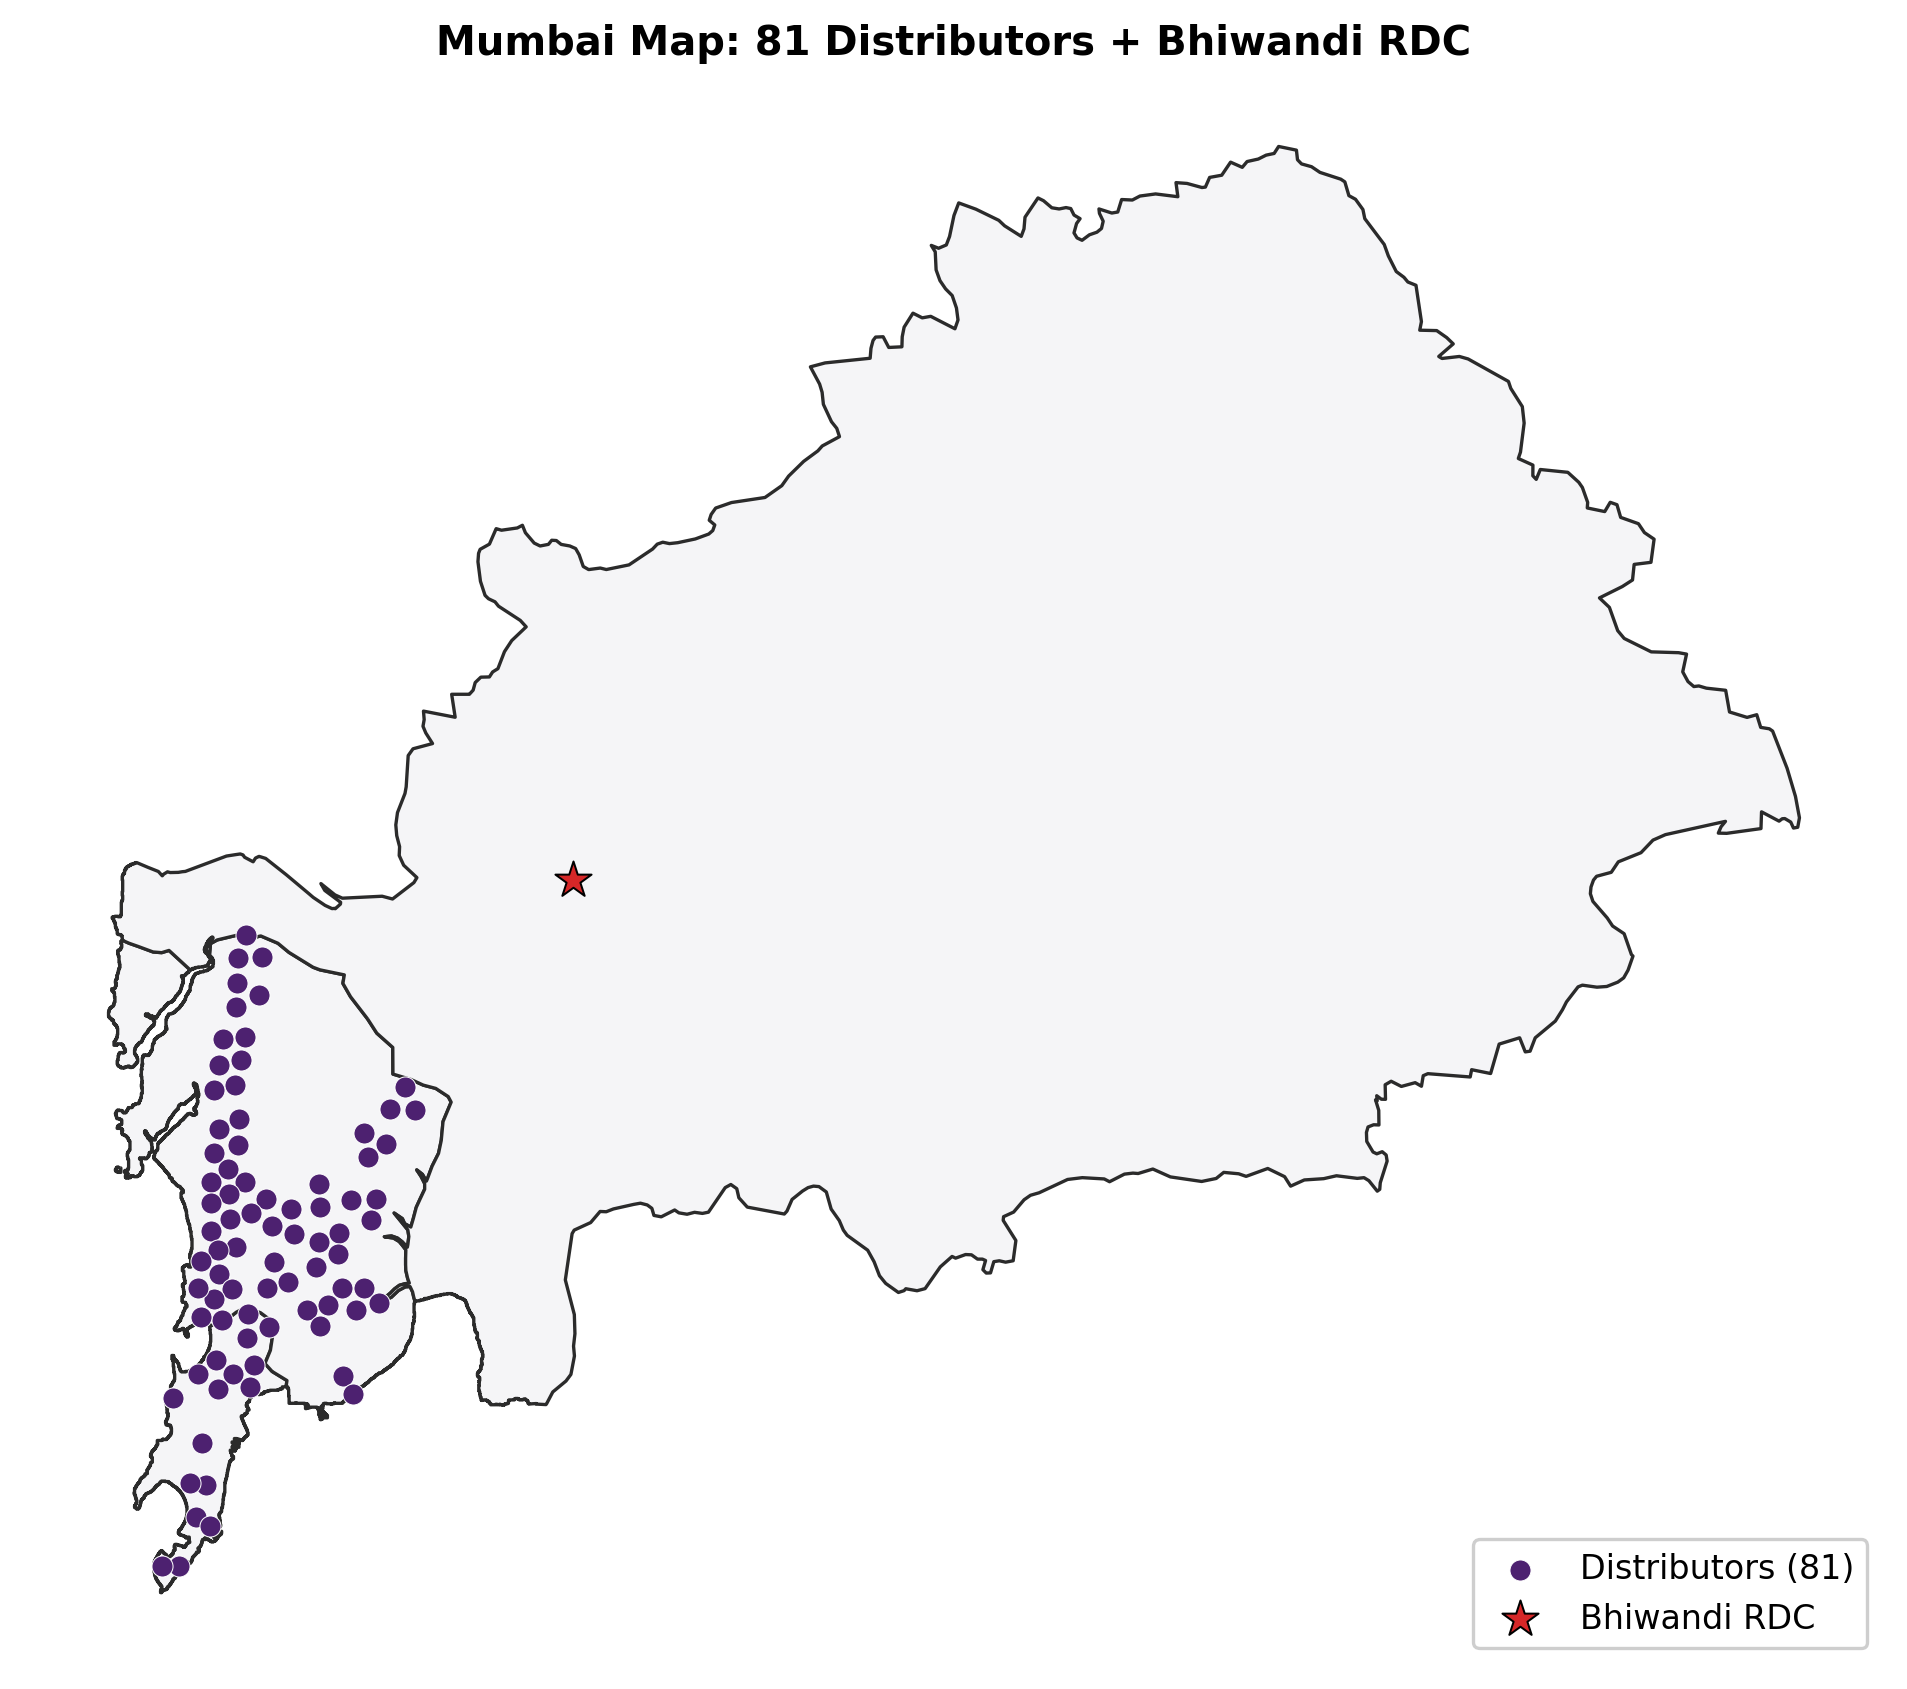

In [20]:
# ================================================================
# Mumbai Outline Map + 111 Distributors + Bhiwandi RDC (static PNG)
# ================================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.ops import unary_union

# -----------------------
# 1) Inputs & parameters
# -----------------------
# Path to GADM India Level-2 shapefile (downloaded from gadm.org)
GADM_LEVEL2_SHP = Path("gadm41_IND_2.shp")   # <-- set this to your local path

# Distributors CSV (provide at least one)
IN_WITH_DIST = Path("mumbai_81_distributors_from_bhiwandi.csv")  # distances ignored
IN_BASE      = Path("mumbai_81_distributors.csv")

# Bhiwandi RDC (assumed; change if you have precise coords)
RDC_LAT = 19.3002
RDC_LON = 73.0588
RDC_NAME = "Bhiwandi RDC"

# District filter (names can vary by GADM build)
MAHA_STATE_NAME = "Maharashtra"
DISTRICT_CANDIDATES = {"Mumbai", "Mumbai City", "Mumbai Suburban", "Thane"}

# Style
FIG_W, FIG_H = 10, 10
DPI = 240
BG = "white"
CITY_FILL = "#f5f5f7"
CITY_EDGE = "#2b2b2b"
CITY_EDGE_W = 1.0

DIST_COLOR = "#4d2170"   # distributors (blue)
DIST_SIZE  = 40
RDC_COLOR  = "#d62728"   # RDC (red)
RDC_SIZE   = 130

# -----------------------
# 2) Load distributors
# -----------------------
if IN_WITH_DIST.exists():
    df = pd.read_csv(IN_WITH_DIST)
elif IN_BASE.exists():
    df = pd.read_csv(IN_BASE)
else:
    raise FileNotFoundError(
        "Provide 'mumbai_81_distributors_from_bhiwandi.csv' or 'mumbai_81_distributors.csv'."
    )

df.columns = [c.lower() for c in df.columns]
if not {"lat", "lon"}.issubset(df.columns):
    raise ValueError("CSV must contain columns 'lat' and 'lon'.")

# -----------------------
# 3) Load GADM districts
# -----------------------
if not GADM_LEVEL2_SHP.exists():
    raise FileNotFoundError(
        f"GADM shapefile not found at {GADM_LEVEL2_SHP}. "
        "Download gadm41_IND_shp.zip from gadm.org and set the path to gadm41_IND_2.shp."
    )

adm2 = gpd.read_file(GADM_LEVEL2_SHP)

# Inspect columns to find the state and district name columns (usually NAME_1 and NAME_2)
name1 = "NAME_1" if "NAME_1" in adm2.columns else [c for c in adm2.columns if c.upper().endswith("_1")][0]
name2 = "NAME_2" if "NAME_2" in adm2.columns else [c for c in adm2.columns if c.upper().endswith("_2")][0]

# Filter to Maharashtra
mh = adm2[adm2[name1] == MAHA_STATE_NAME].copy()

# If you're unsure which district names exist, uncomment to print and adjust DISTRICT_CANDIDATES if needed
# print(sorted(mh[name2].unique()))

# Keep Mumbai/Thane polygons
mask = mh[name2].isin(DISTRICT_CANDIDATES)
mumbai_like = mh[mask].copy()
if mumbai_like.empty:
    raise ValueError(
        "Could not match Mumbai/Thane in your GADM build. "
        "Print mh[name2].unique() and update DISTRICT_CANDIDATES accordingly."
    )

# Ensure WGS84 (lat/lon)
mumbai_like = mumbai_like.to_crs(4326)

# Merge the selected polygons for a tight extent
merged_geom = unary_union(mumbai_like.geometry.values)
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geom], crs="EPSG:4326")

# -----------------------
# 4) Build the figure
# -----------------------
fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI)
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

# 4a) Plot the filled city/district polygons first (the "Mumbai map")
mumbai_like.plot(ax=ax, color=CITY_FILL, edgecolor=CITY_EDGE, linewidth=CITY_EDGE_W, zorder=1)

# 4b) Plot distributors (points)
ax.scatter(
    df["lon"], df["lat"],
    s=DIST_SIZE, c=DIST_COLOR, edgecolor="white", linewidth=0.3,
    zorder=3, label="Distributors (81)"
)

# 4c) Plot RDC (star)
ax.scatter(
    [RDC_LON], [RDC_LAT],
    s=RDC_SIZE, c=RDC_COLOR, marker="*",
    edgecolor="black", linewidth=0.6, zorder=4, label=RDC_NAME
)

# -----------------------
# 5) Clean layout
# -----------------------
ax.set_title("Mumbai Map: 81 Distributors + Bhiwandi RDC", fontsize=12, weight="bold")
# Zoom to polygon extent with a small padding
minx, miny, maxx, maxy = merged_gdf.total_bounds
pad_x = (maxx - minx) * 0.05
pad_y = (maxy - miny) * 0.05
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

# Hide axis ticks/labels to keep a map look
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.legend(loc="lower right", frameon=True, facecolor="white", framealpha=0.95)

#out_png = "mumbai_81_distributors_RDC_map.png"
#plt.savefig(out_png, dpi=DPI, facecolor=BG, bbox_inches="tight")
#print(f"Saved PNG: {out_png}")

'''
# Optional JPG
try:
    from PIL import Image
    Image.open(out_png).convert("RGB").save("mumbai_distributors_map.jpg", quality=92)
    print("Saved JPG: mumbai_distributors_map.jpg")
except Exception:
    pass
'''

## Find Dark Store locations in Mumbai ##

In [ ]:
# ================================================================
# Quick Commerce Dark Stores in Mumbai - Geocoded Coordinates
# ================================================================
from geopy.geocoders import Nominatim
import pandas as pd
import time

# ------------------------------
# 1) Dark store area names
# ------------------------------
dark_stores = {
    "Zepto": [
        "Bhandup, Mumbai", "Santacruz, Mumbai", "Bhayander, Mumbai", "Andheri West, Mumbai",
        "Matunga, Mumbai", "Kharghar, Navi Mumbai", "Andheri East, Mumbai", "Malad, Mumbai",
        "Bandra West, Mumbai", "Vashi Sector 19A, Navi Mumbai", "Powai, Mumbai",
        "Lower Parel, Mumbai", "BKC, Mumbai", "Kothari Compound, Thane", "Borivali, Mumbai",
        "Goregaon East, Mumbai", "Panvel, Navi Mumbai", "Ghatkopar West, Mumbai",
        "Kandivali West, Mumbai", "Chembur, Mumbai", "Dombivli West, Thane", "Marol, Mumbai",
        "Mira Road, Mumbai", "Mumbai Central, Mumbai", "Dharavi, Mumbai"
    ],
    "Blinkit": [
        "Colaba, Mumbai", "Andheri, Mumbai", "Bandra, Mumbai", "Powai, Mumbai", "Navi Mumbai",
        "Juhu, Mumbai", "Malad, Mumbai", "Borivali, Mumbai", "Thane, Mumbai", "Worli, Mumbai",
        "Dadar, Mumbai", "Lower Parel, Mumbai", "Goregaon, Mumbai", "Kandivali, Mumbai",
        "Chembur, Mumbai", "Ghatkopar, Mumbai", "Mulund, Mumbai", "Mira Road, Mumbai",
        "Vasai, Mumbai", "Vikhroli, Mumbai", "Vashi, Mumbai"
    ]
}

# ------------------------------
# 2) Geocode each area
# ------------------------------
geolocator = Nominatim(user_agent="mumbai_darkstores_mapper")
records = []

for platform, areas in dark_stores.items():
    for area in areas:
        try:
            location = geolocator.geocode(area, timeout=10)
            if location:
                records.append({
                    "platform": platform,
                    "area": area,
                    "latitude": location.latitude,
                    "longitude": location.longitude
                })
                print(f"Located {area} → ({location.latitude:.5f}, {location.longitude:.5f})")
            else:
                print(f"Could not geocode: {area}")
        except Exception as e:
            print(f"Error geocoding {area}: {e}")
        time.sleep(1)  # pause to respect Nominatim usage policy

# ------------------------------
# 3) Save to CSV
# ------------------------------
#df = pd.DataFrame(records)
#df.to_csv("dark_stores_mumbai.csv", index=False)
#print("\nSaved to dark_stores_mumbai.csv")

## Place Dark Stores in Mumbai Map ##

Loaded boundary: Mumbai, Maharashtra, India
Loaded boundary: Brihanmumbai Municipal Corporation, Maharashtra, India
Loaded boundary: Mumbai Suburban, Maharashtra, India
Loaded boundary: Mumbai City, Maharashtra, India
Loaded boundary: Thane, Maharashtra, India
Loaded boundary: Navi Mumbai, Maharashtra, India
Skipping 'Mira-Bhayandar, Maharashtra, India' (Nominatim did not geocode query 'Mira-Bhayandar, Maharashtra, India' to a geometry of type (Multi)Polygon.)
Loaded boundary: Vasai-Virar, Maharashtra, India
Loaded boundary: Kalyan-Dombivli, Maharashtra, India
Loaded boundary: Panvel, Maharashtra, India
Loaded boundary: Ulhasnagar, Maharashtra, India
Loaded boundary: Bhiwandi, Maharashtra, India


'\n# Also save JPG for PPT\ntry:\n    from PIL import Image\n    Image.open(out_png).convert("RGB").save("mumbai_darkstores_map.jpg", quality=92)\n    print("Saved JPG: mumbai_darkstores_map.jpg")\nexcept Exception:\n    pass\n'

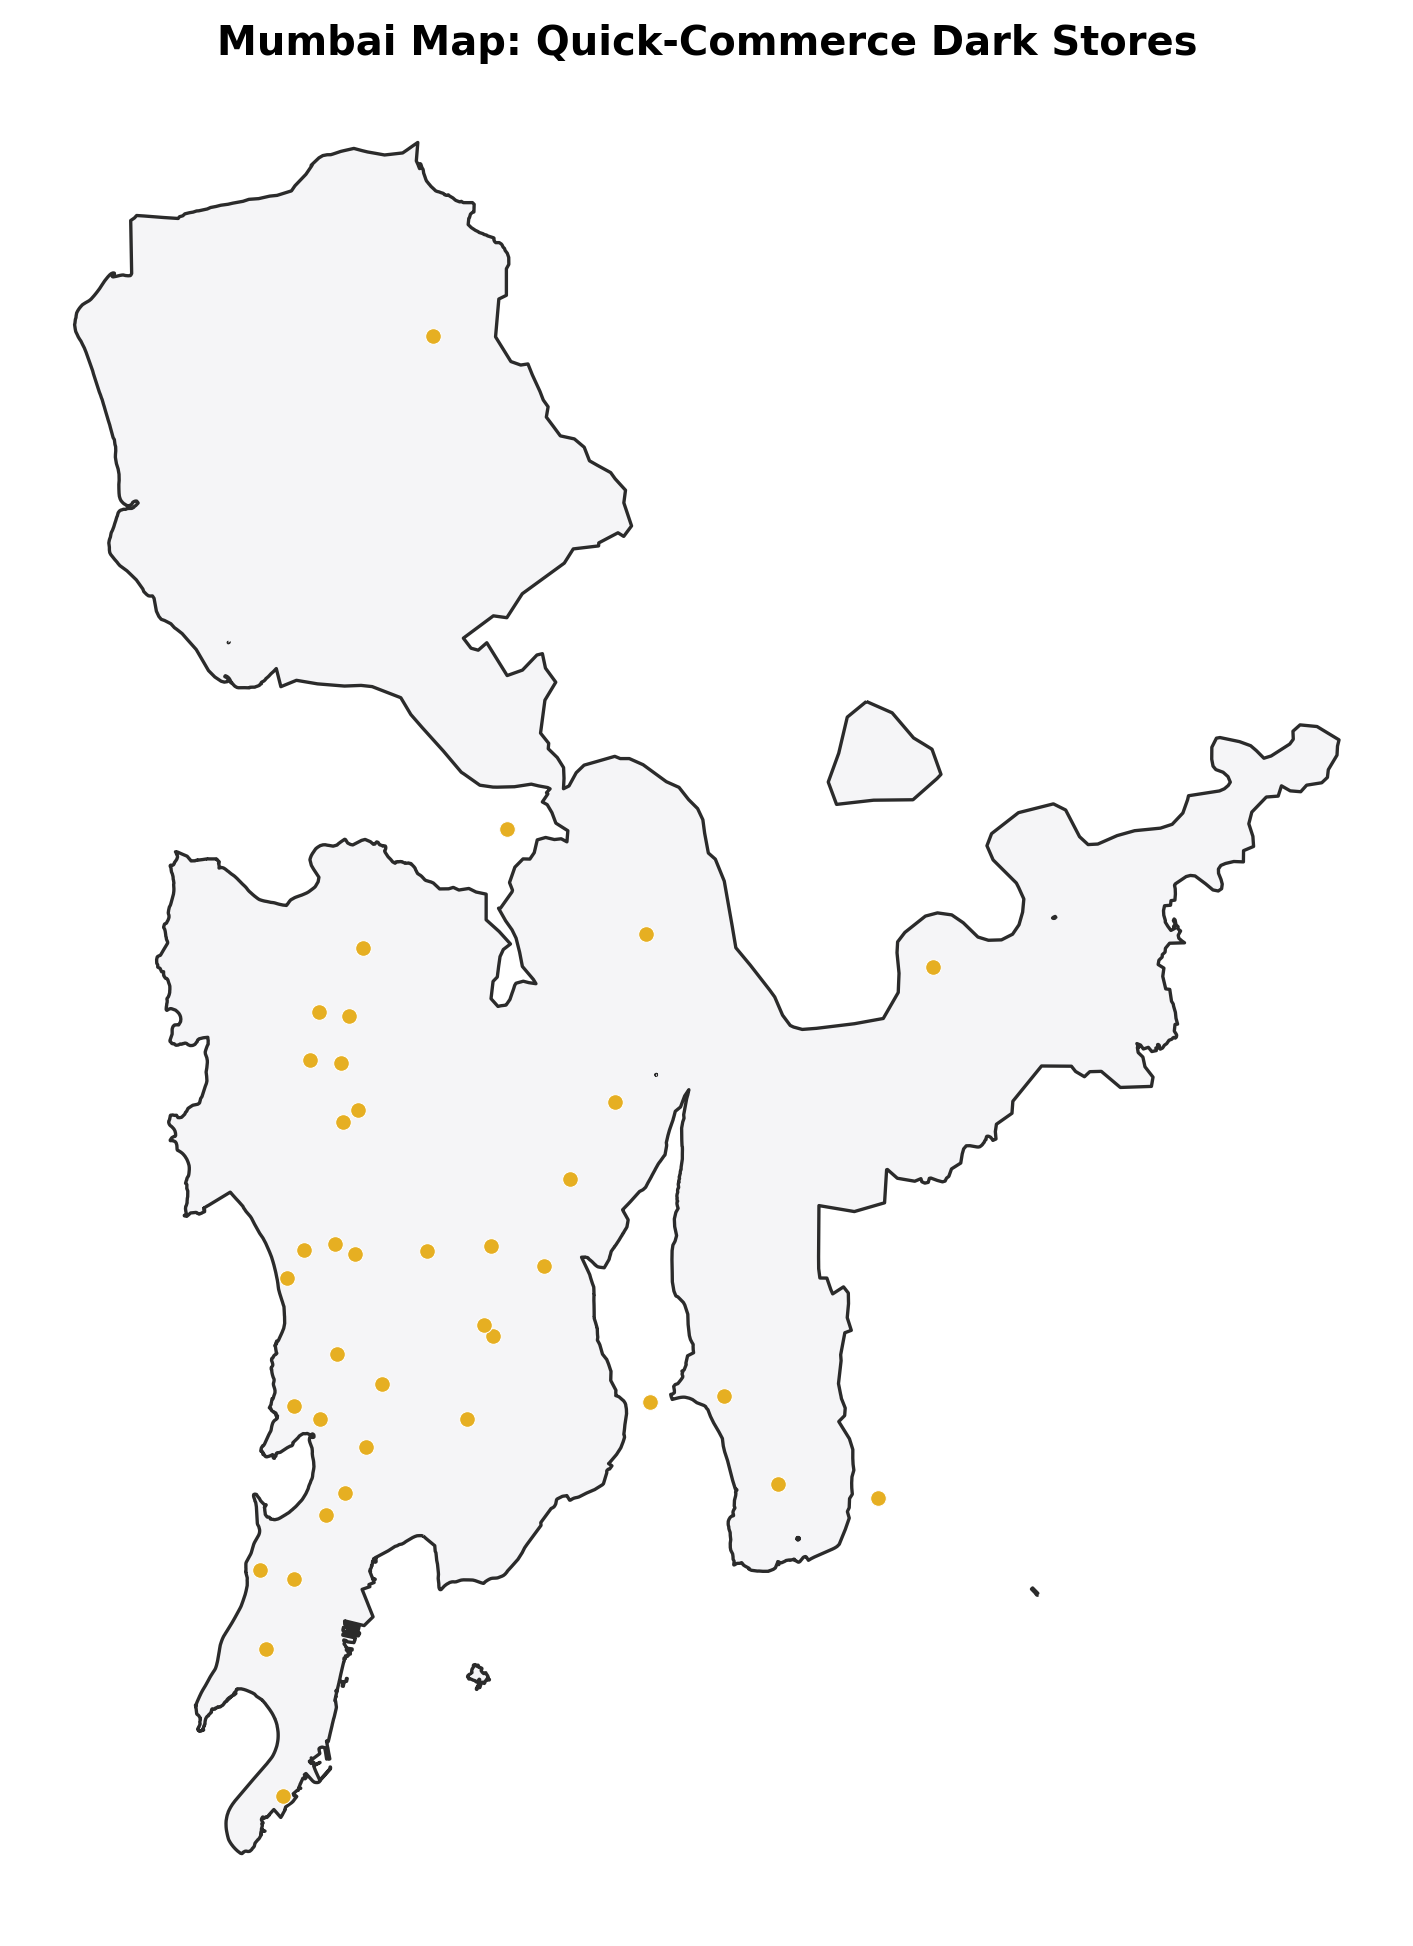

In [25]:
# ======================================================================
# Mumbai Outline (from OpenStreetMap via osmnx) + Dark Store Locations
# Inputs:
#   - dark_stores_mumbai.csv  (platform, area, latitude, longitude)
# Output:
#   - mumbai_darkstores_map.png  and  mumbai_darkstores_map.jpg
# ======================================================================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.ops import unary_union
import osmnx as ox

# ---- 1) Load dark store points ----
IN_CSV = Path("dark_stores_mumbai.csv")
if not IN_CSV.exists():
    raise FileNotFoundError("dark_stores_mumbai.csv not found. Create it with the geocoding step first.")

df = pd.read_csv(IN_CSV)
df.columns = [c.strip().lower() for c in df.columns]
required = {"platform", "area", "latitude", "longitude"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV must contain {required}. Found: {set(df.columns)}")

# keep valid coords only
df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df = df.dropna(subset=["latitude", "longitude"]).copy()

# ---- 2) Get Mumbai metro outlines from OSM (admin polygons) ----
# We union several municipal/admin bodies so Navi Mumbai / Thane / Panvel etc. are included.
PLACE_CANDIDATES = [
    "Mumbai, Maharashtra, India",
    "Brihanmumbai Municipal Corporation, Maharashtra, India",
    "Mumbai Suburban, Maharashtra, India",
    "Mumbai City, Maharashtra, India",
    "Thane, Maharashtra, India",
    "Navi Mumbai, Maharashtra, India",
    "Mira-Bhayandar, Maharashtra, India",
    "Vasai-Virar, Maharashtra, India",
    "Kalyan-Dombivli, Maharashtra, India",
    "Panvel, Maharashtra, India",
    "Ulhasnagar, Maharashtra, India",
    "Bhiwandi, Maharashtra, India",
]

polys = []
for place in PLACE_CANDIDATES:
    try:
        gdf = ox.geocode_to_gdf(place)
        # Keep polygon/multipolygon only
        gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])]
        if not gdf.empty:
            polys.append(gdf.to_crs(4326))
            print(f"Loaded boundary: {place}")
    except Exception as e:
        print(f"Skipping '{place}' ({e})")

if not polys:
    raise RuntimeError("Could not fetch any Mumbai-area polygons from OSM. Check your internet connection.")

metro = pd.concat(polys, ignore_index=True)
# Dissolve to a single geometry to get a clean outer boundary
merged_geom = unary_union(metro.geometry.values)
merged_gdf = gpd.GeoDataFrame(geometry=[merged_geom], crs="EPSG:4326")

# ---- 3) Plot: outline FIRST, then points ----
FIG_W, FIG_H, DPI = 10, 10, 240
BG = "white"
CITY_FILL = "#f5f5f7"
CITY_EDGE = "#2b2b2b"
CITY_EDGE_W = 1.0

# Colors per platform (extend as needed)
PLATFORM_COLORS = {
    "zepto": "#e6af22",
    "blinkit": "#e6af22",
    "instamart": "#e6af22",
    "bb now": "#e6af22",
}
DEFAULT_COLOR = "#e6af22"
POINT_SIZE = 22

fig, ax = plt.subplots(figsize=(FIG_W, FIG_H), dpi=DPI)
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

# 3a) Outline
merged_gdf.plot(ax=ax, color=CITY_FILL, edgecolor=CITY_EDGE, linewidth=CITY_EDGE_W, zorder=1)

# 3b) Points
for platform, sub in df.groupby(df["platform"].str.lower()):
    color = PLATFORM_COLORS.get(platform, DEFAULT_COLOR)
    ax.scatter(
        sub["longitude"], sub["latitude"],
        s=POINT_SIZE, c=color, edgecolor="white", linewidth=0.3, zorder=3, label=platform.title()
    )

# 3c) Cosmetics
ax.set_title("Mumbai Map: Quick-Commerce Dark Stores", fontsize=12, weight="bold")
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

# Fit to outline bounds with a small padding
minx, miny, maxx, maxy = merged_gdf.total_bounds
pad_x = (maxx - minx) * 0.04
pad_y = (maxy - miny) * 0.04
ax.set_xlim(minx - pad_x, maxx + pad_x)
ax.set_ylim(miny - pad_y, maxy + pad_y)

'''
# Legend
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(loc="lower left", frameon=True, facecolor="white", framealpha=0.95, title="Platform")
'''

# ---- 4) Save ----
'''
out_png = "mumbai_darkstores_map.png"
plt.savefig(out_png, dpi=DPI, facecolor=BG, bbox_inches="tight")
print(f"Saved PNG: {out_png}")
'''
'''
# Also save JPG for PPT
try:
    from PIL import Image
    Image.open(out_png).convert("RGB").save("mumbai_darkstores_map.jpg", quality=92)
    print("Saved JPG: mumbai_darkstores_map.jpg")
except Exception:
    pass
'''

## Find Distance of Darks Stores from RDC ##

In [27]:
# ------------------------------------------------------------
# Distances from Bhiwandi RDC to each (geocoded) dark store
# Input : dark_stores_mumbai.csv  (platform, area, latitude, longitude)
# Output: dark_stores_mumbai_with_distance.csv
# ------------------------------------------------------------
import math
from pathlib import Path
import pandas as pd

# --- 1) Bhiwandi RDC coordinates (ASSUMPTION: update if you have exact pin) ---
RDC_LAT = 19.3002
RDC_LON = 73.0588
RDC_NAME = "Bhiwandi RDC (Assumed)"

# --- 2) Load geocoded dark stores ---
in_csv = Path("dark_stores_mumbai.csv")
if not in_csv.exists():
    raise FileNotFoundError(
        "Input 'dark_stores_mumbai.csv' not found. "
        "Run the geocoding step first to create it."
    )

df = pd.read_csv(in_csv)

# Normalize column names (tolerate case differences)
df.columns = [c.strip().lower() for c in df.columns]
required = {"platform", "area", "latitude", "longitude"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV must have columns {required}. Found: {set(df.columns)}")

# --- 3) Haversine distance (km) ---
def haversine_km(lat1, lon1, lat2, lon2):
    """Great-circle distance between two points on Earth (km) using Haversine formula."""
    R = 6371.0  # Earth's mean radius (km)
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlmb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlmb/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Clean up any non-numeric lat/lon and drop rows that can't be used
df["latitude"]  = pd.to_numeric(df["latitude"], errors="coerce")
df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
df = df.dropna(subset=["latitude", "longitude"]).copy()

# Compute distance
df["rdc_lat"] = RDC_LAT
df["rdc_lon"] = RDC_LON
df["rdc_name"] = RDC_NAME
df["distance_km"] = df.apply(
    lambda r: haversine_km(RDC_LAT, RDC_LON, float(r["latitude"]), float(r["longitude"])),
    axis=1
)

# --- 4) Arrange columns nicely & save ---
out_cols = ["platform", "area", "latitude", "longitude", "rdc_name", "rdc_lat", "rdc_lon", "distance_km"]
result = df[out_cols].sort_values(["platform", "distance_km"]).reset_index(drop=True)

result = result[["platform", "area", "rdc_name", "distance_km"]]
'''
# Save to CSV
out_csv = "dark_stores_mumbai_with_distance.csv"
result.to_csv(out_csv, index=False)
'''
# Quick preview
print(result.head(10).to_string(index=False))
#print(f"\nSaved: {out_csv}")

platform              area               rdc_name  distance_km
 Blinkit    Mulund, Mumbai Bhiwandi RDC (Assumed)        17.85
 Blinkit  Borivali, Mumbai Bhiwandi RDC (Assumed)        22.58
 Blinkit Kandivali, Mumbai Bhiwandi RDC (Assumed)        24.22
 Blinkit  Vikhroli, Mumbai Bhiwandi RDC (Assumed)        25.08
 Blinkit     Vasai, Mumbai Bhiwandi RDC (Assumed)        25.18
 Blinkit     Malad, Mumbai Bhiwandi RDC (Assumed)        25.42
 Blinkit     Powai, Mumbai Bhiwandi RDC (Assumed)        25.69
 Blinkit Mira Road, Mumbai Bhiwandi RDC (Assumed)        26.46
 Blinkit  Goregaon, Mumbai Bhiwandi RDC (Assumed)        26.63
 Blinkit     Vashi, Mumbai Bhiwandi RDC (Assumed)        27.09


## Find Nearest and Second Nearest Distributor from each Dark Store ##

In [28]:
# ==========================================
# Nearest & 2nd-Nearest Distributor per Dark Store (Haversine)
# ==========================================
# pip install pandas numpy scikit-learn

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree

# -----------------------
# 1) Inputs & parameters
# -----------------------
DARKSTORES_CSV   = Path("dark_stores_mumbai.csv")        # <-- set your file
DISTRIBUTORS_CSV = Path("mumbai_81_distributors.csv")      # <-- set your file
OUT_CSV          = Path("darkstore_2_nearest_distributor.csv")

EARTH_RADIUS_KM = 6371.0088  # IUGG mean Earth radius

# -----------------------
# 2) Utilities
# -----------------------
def _find_lat_lon_cols(columns):
    cols = {c.lower(): c for c in columns}
    candidates = [
        ("lat", "lon"),
        ("latitude", "longitude"),
        ("y", "x"),
    ]
    for la, lo in candidates:
        if la in cols and lo in cols:
            return cols[la], cols[lo]
    raise ValueError("Could not detect lat/lon columns. Expected one of: "
                     "lat/lon or latitude/longitude (case-insensitive).")

def _prep_df(path, id_hint=None, name_hint=None, default_prefix="ID_"):
    if not Path(path).exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path)
    if df.empty:
        raise ValueError(f"No rows in {path}")
    lat_col, lon_col = _find_lat_lon_cols(df.columns)
    df = df.rename(columns={lat_col: "lat", lon_col: "lon"})
    df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
    df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
    df = df.dropna(subset=["lat", "lon"])
    df = df[(df["lat"].between(-90, 90)) & (df["lon"].between(-180, 180))].copy()

    # IDs & names (keep if present; else auto-create)
    if id_hint and id_hint in df.columns:
        df["id"] = df[id_hint]
    else:
        df["id"] = [f"{default_prefix}{i+1}" for i in range(len(df))]
    if name_hint and name_hint in df.columns:
        df["name"] = df[name_hint]
    else:
        df["name"] = df["id"].astype(str)

    # Keep only needed cols
    return df[["id", "name", "lat", "lon"]].reset_index(drop=True)

# -----------------------
# 3) Load & prepare data
# -----------------------
dark = _prep_df(DARKSTORES_CSV, id_hint="darkstore_id", name_hint="darkstore_name", default_prefix="DS_")
dist = _prep_df(DISTRIBUTORS_CSV, id_hint="distributor_id", name_hint="distributor_name", default_prefix="D_")

if len(dist) == 0:
    raise ValueError("No distributors found after cleaning.")
if len(dark) == 0:
    raise ValueError("No dark stores found after cleaning.")

# If only one distributor exists, we’ll mirror it for the 'second nearest' to keep outputs consistent
k_neighbors = 2 if len(dist) >= 2 else 1

# -----------------------
# 4) BallTree in radians (Haversine)
# -----------------------
dark_rad = np.radians(dark[["lat", "lon"]].values)
dist_rad = np.radians(dist[["lat", "lon"]].values)

tree = BallTree(dist_rad, metric="haversine")

# Query k nearest
dist_radians, nn_idx = tree.query(dark_rad, k=k_neighbors)  # shapes: (M,k)
dist_km = dist_radians * EARTH_RADIUS_KM

# If only 1 distributor, duplicate columns to provide "second" as same
if k_neighbors == 1:
    nn_idx = np.repeat(nn_idx, 2, axis=1)
    dist_km = np.repeat(dist_km, 2, axis=1)

# -----------------------
# 5) Build tidy output
# -----------------------
nearest1 = dist.iloc[nn_idx[:, 0]].reset_index(drop=True)
nearest2 = dist.iloc[nn_idx[:, 1]].reset_index(drop=True)

out = pd.DataFrame({
    "darkstore_id":   dark["id"],
    "darkstore_name": dark["name"],
    "dark_lat":       dark["lat"],
    "dark_lon":       dark["lon"],

    "nearest1_distributor_id":   nearest1["id"].values,
    "nearest1_distributor_name": nearest1["name"].values,
    "nearest1_lat":              nearest1["lat"].values,
    "nearest1_lon":              nearest1["lon"].values,
    "nearest1_distance_km":      np.round(dist_km[:, 0], 3),

    "nearest2_distributor_id":   nearest2["id"].values,
    "nearest2_distributor_name": nearest2["name"].values,
    "nearest2_lat":              nearest2["lat"].values,
    "nearest2_lon":              nearest2["lon"].values,
    "nearest2_distance_km":      np.round(dist_km[:, 1], 3),
})

# Diagnostic columns (optional but useful)
out["distance_gap_km"] = np.round(out["nearest2_distance_km"] - out["nearest1_distance_km"], 3)
out["nearest_same_point_flag"] = (
    (out["nearest1_lat"] == out["nearest2_lat"]) &
    (out["nearest1_lon"] == out["nearest2_lon"])
)

out = out [['darkstore_id','nearest1_distributor_id','nearest1_distance_km','nearest2_distributor_id','nearest2_distance_km','distance_gap_km']]

# -----------------------
# 6) Save & preview
# -----------------------
#out.to_csv(OUT_CSV, index=False)
#print(f"Saved: {OUT_CSV}")
print(out.head(10))

  darkstore_id  nearest1_distributor_id  nearest1_distance_km  \
0         DS_1                       71                  0.56   
1         DS_2                       49                  0.65   
2         DS_3                       19                  5.04   
3         DS_4                       39                  0.58   
4         DS_5                       51                  0.95   
5         DS_6                       78                 12.93   
6         DS_7                       67                  0.68   
7         DS_8                       35                  0.67   
8         DS_9                        9                  0.67   
9        DS_10                       72                  0.74   

   nearest2_distributor_id  nearest2_distance_km  distance_gap_km  
0                       37                  0.88             0.32  
1                       45                  1.09             0.44  
2                       43                  5.70             0.66  
3           